* Let's start wth looking at features of sepsis , from physionet.
    * https://physionet.org/content/challenge-2019/1.0.0/
 
* later, smarter links - https://chat.openai.com/c/c9e96408-87ab-4b0d-b4a0-8f01adccf794  (prompt call)  ;
* https://chat.openai.com/c/1e374834-ed6b-4bcd-9dc9-fa9de5134450 - early onset...

* Pubmed evidence+ Relations extractor work (not using CUIs) - relevant esearch? (lacks paper) - https://ailabs.tw/healthcare/extracting-the-most-significant-and-relevant-relational-facts-from-large-scale-biomedical-literature/
    * scispaCy ORE
  * Doesnt seem HQ, but is relevant?

* https://oyewusiwuraola.medium.com/how-to-use-scispacy-entity-linkers-for-biomedical-named-entities-7cf13b29ef67
    *  Also has examples of using the different scispacy entity type models
*  https://github.com/WuraolaOyewusi/How-to-use-scispaCy-Entity-Linkers-for-Biomedical-Named-Entities/blob/master/scispacy_entities_extractions_and_linkers(uncleared_outputs)_.ipynb

*  * Also relevant - Hetionet (in PyKeen, DGL-KE) - finding important paths between 2 nodes. drug repurposing focused initially.

 
Install note:
* scispacy - you need python 3.10 (for nmslib to install ok)


Alt tool: Metamap
* https://gweissman.github.io/post/using-metamap-with-python-to-access-the-umls-metathesaurus-a-quick-start-guide/
* https://github.com/AnthonyMRios/pymetamap

* Google cloud natural health NLP - supports medical NER etc', including UMLS/"Metatheasauurs" names
    * https://cloud.google.com/healthcare-api/docs/concepts/nlp#supported_medical_vocabularies
-------------------------------------------

UMLS Semantic types (TUI) and groups (could use to filter results):
* https://lhncbc.nlm.nih.gov/ii/tools/MetaMap/documentation/SemanticTypesAndGroups.html



**Idea**: Could filter not just by min/max feature level, also by aggregating by feature * __TUI__. ?



### Betweenness -  as a continous measure of similarity/ # short paths (instead of binary/discrete cutoff)? 
* https://docs.google.com/document/d/15jPnznpNyl9CubrmNOsCdABxj3DfKR8epvyzAXqJMbo/edit?_sm_vck=Qn6Rjr36TvSsrHSrFNQMHPtdVHRDnsBfRMBTN5MdJHTjrJnD5WVr#heading=h.bw9q0hr5kp2f
* Betweenness centrality (networkX) - as a continuous score for similarity (between concepts/feature and target(s)), instead of binary/discrete ?
    * Edge_betweenness_centrality ?
    * Edge_betweenness_centrality_subset
*  networkX - load from pandas ; https://developer.nvidia.com/blog/accelerating-networkx-on-nvidia-gpus-for-high-performance-graph-analytics/  ; nx.from_pandas_edgelist 
*  Graphtool (faster); https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.centrality.closeness.html 
* Rustworkx.edge_betweenness_centrality
* https://www.kaggle.com/code/rahulgoel1106/network-centrality-using-networkx 



### Filter idea: 
* drop duplicates by #KG_hits and sorted sim score +- add in NEL score = keep top hit and that if not in kg. 
* Could check KG paths, after filtering for relevant predicates, e.g. is_a, precedes, etc' (and check sinple paths on that)


* How to use scispaCy Entity Linkers for Biomedical Named Entities*
    * https://oyewusiwuraola.medium.com/how-to-use-scispacy-entity-linkers-for-biomedical-named-entities-7cf13b29ef67
    * Very relevant! Also uses the other scispacy NER corpuses/models to extract first - e.g. craft, then links those candidates

`https://towardsdatascience.com/building-a-biomedical-entity-linker-with-llms-d385cb85c15a`
* LLMs, mistral, compares to scispacy inc NEL

* https://www.kaggle.com/code/daking/extracting-entities-linked-to-umls-with-scispacy
    * "One useful thing to play around with here is **filtering the linked entities based on your use case and the UMLS type tree, as types higher up on the tree indicate more general entities**"

* “Evaluating Explanations from AI Algorithms for Clinical Decision-Making: A Social Science-based Approach” *
- Very relevant to what I want to do!
- uses evidence from pubmed KG/semmed! 02.2024.
- https://www.medrxiv.org/content/10.1101/2024.02.26.24303365v1.full.pdf 


* Could improve FS with boruta, other methods  - ARFS
* https://github.com/ThomasBury/arfs/blob/main/docs/notebooks/basic_feature_selection.ipynb

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # Import tqdm for the progress bar

## scispacy, medspacy, medcat, quickumls, semrep...
import networkx as nx
from itertools import combinations

import spacy
import scispacy
from itertools import compress
from scispacy.linking import EntityLinker
from scispacy.abbreviation import AbbreviationDetector ## https://github.com/allenai/scispacy?tab=readme-ov-file#example-usage

import sys, os ## append parent path to dir to allow import
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)
from utils import get_sentence_pairs_similarity
from utils import anti_join_df
from utils import *

from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker

%load_ext autoreload
%autoreload 2

/home/ddofer/anaconda3/envs/IntFeat/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ddofer/anaconda3/envs/IntFeat/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
SAVE_OUTPUTS = False # True
MIN_EVIDENCE_FILTER = 1#1#2
######

In [3]:
# # ### Gallstones and related gall bladder disease
# # ## previous old input: # INPUT_FEATURES_REPORT_PATH = "../ukb_gallstone_feature_report.csv"
# ## input:
INPUT_FEATURES_REPORT_PATH = "../gallstone_chol_ipw_feature_report.csv"
## output path
CANDIDATE_NOVEL_CUIS_FILEPATH = "../candidate_novel_cuis_chol.csv" 
TARGET_NAME = "GALLSTONES, Cholelithiasis"
additional_target_cui_terms_list = ["C0008325" , "C0008311"] # cholecystitis, Cholangitis - for gallstones

# ####### gout: 
# ## input:
INPUT_FEATURES_REPORT_PATH = "../gout_ipw_feature_report.csv"
# ## output path
CANDIDATE_NOVEL_CUIS_FILEPATH = "../candidate_novel_cuis_gout.csv" 
TARGET_NAME = "Gout"
additional_target_cui_terms_list = []

# # ###### Celiac: 
# ## input:
# INPUT_FEATURES_REPORT_PATH = "../celiac_feature_report.csv"
# ## output path
# CANDIDATE_NOVEL_CUIS_FILEPATH = "../candidate_novel_celiac.csv" 

# TARGET_NAME = "Coeliac disease" # / Celiac
# additional_target_cui_terms_list = ["C5139492"] # gluten allergy


# # ######### Multiple Sclerosis (MS)
# INPUT_FEATURES_REPORT_PATH = "../MS_ipw_feature_report.csv"
# CANDIDATE_NOVEL_CUIS_FILEPATH = "../candidate_novel_MS.csv" 

# TARGET_NAME = "Multiple Sclerosis"
# additional_target_cui_terms_list = []


# # ######### Spine Degeneration
# INPUT_FEATURES_REPORT_PATH = "../spine_degen_feature_report.csv"
# CANDIDATE_NOVEL_CUIS_FILEPATH = "../candidate_novel_spine.csv" 

# TARGET_NAME = "Spine degeneration"
# additional_target_cui_terms_list = ["C0158266", "C0850918" , "C0021818", "C0038019", "C0158252","C0423673","C0024031"]


# # ######### Oesophagus cancer
# INPUT_FEATURES_REPORT_PATH = "../oesophagus_feature_report.csv"
# CANDIDATE_NOVEL_CUIS_FILEPATH = "../candidate_novel_oesophagus.csv" 

# TARGET_NAME = "Esophageal cancer"
# additional_target_cui_terms_list = []


In [4]:
REMOVE_CUI_TERMS_LIST = ['Prieto syndrome',"Polarized Reflectance Spectroscopy", # mistaken extraction from PRS - drop it for now for cleanliness 
'Standard (qualifier)', 'Standard base excess calculation technique',
       'Standard of Care', 'Spatial Frequency', 'Disease',
       'Statistical Frequency', 'Kind of quantity - Frequency','Concentration measurement',
'Concentration measurement', 'Illness (finding)','Concentration Ratio',
   "Special" , "ActInformationPrivacyReason <operations>","Left sided","Left","Right",
                         "Table Cell Horizontal Align - left","Query Quantity Unit - Records","Up",
                         "Qualification",
                         "Visit", "Total","Participant","Overall", "Right sided", "Left sided",
                         "Take","Percent (qualifier value)",
                        ]

### Load processed semmed db
* ths version has 1 row per triple.
* `Count` is the number of unique PMIDs the triple has appeared in
* Idea: we could filter for triples that appear at least K times. +- filter papers with less than 1-2 citations

In [5]:
df_kg = pd.read_parquet("predications.parquet")
df_kg

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,first_year_pair,first_year_triple,counts
1880,C0087111,Therapeutic procedure,topp,TREATS,False,C0030705,Patients,podg,False,1902,1902,151392
669,C0040395,tomography,diap,USES,True,C1441526,COMPUTED,lbpr,False,1956,1956,143421
2937,C0012634,Disease,dsyn,PROCESS_OF,False,C0030705,Patients,humn,False,1902,1902,136269
4635,C0543467,Operative Surgical Procedures,topp,TREATS,True,C0030705,Patients,podg,False,1821,1901,104032
31,C1457887,Symptoms,sosy,PROCESS_OF,False,C0030705,Patients,humn,False,1898,1898,86269
...,...,...,...,...,...,...,...,...,...,...,...,...
87371563,1,A1BG,gngm,AFFECTS,False,C0036421,Systemic Scleroderma,dsyn,True,2019,2019,1
61359900,1,A1BG,gngm,AFFECTS,True,C0028754,Obesity,dsyn,True,2009,2009,1
26550118,1,A1BG,aapp,AFFECTS,True,C0020291,Hydrolysis,npop,True,1983,1983,1
59434220,1,A1BG,gngm,AFFECTS,True,C0005935,Bone Conduction,ortf,True,2017,2017,1


In [6]:
df_kg.nunique()

SUBJECT_CUI          259209
SUBJECT_NAME         277971
SUBJECT_SEMTYPE         132
PREDICATE                62
SUBJECT_NOVELTY           2
OBJECT_CUI           222189
OBJECT_NAME          239669
OBJECT_SEMTYPE          133
OBJECT_NOVELTY            2
first_year_pair         244
first_year_triple       244
counts                 3963
dtype: int64

In [7]:
df_kg.counts.describe().round()

count    27137626.0
mean            5.0
std           110.0
min             1.0
25%             1.0
50%             1.0
75%             2.0
max        151392.0
Name: counts, dtype: float64

### Filtered version
* Could Keep cases with more than ~3 evidences (note: counts of evidences are counts of unique papers with that SVO triple).
* * could laso filter by HQ papers (With external dataset linked to the PMIDs in raw data - e.g. using pubmedKG for citation counts)

In [8]:
print(df_kg.shape[0]) # 26M
df_kg["counts_pair"] = df_kg[["SUBJECT_CUI","OBJECT_CUI","PREDICATE"]].groupby(["SUBJECT_CUI","OBJECT_CUI"],observed=True)["PREDICATE"].transform("size") # count evidence irregardless of predicate
# df_kg = df_kg.loc[df_kg["counts"]>=MIN_EVIDENCE_FILTER].reset_index(drop=True).copy()
df_kg = df_kg.loc[df_kg["counts_pair"]>=MIN_EVIDENCE_FILTER].reset_index(drop=True).copy()
df_kg.drop(columns=["counts_pair"],inplace=True,errors="ignore")
print("After filtering min count")
for c in df_kg.select_dtypes("category").columns:
# remove unobserved categories, in new filtered data
    df_kg[c] = df_kg[c].cat.remove_unused_categories()
print(df_kg.shape[0]) # 4M
print(df_kg.nunique())

27137626
After filtering min count
27137626
SUBJECT_CUI          259209
SUBJECT_NAME         277971
SUBJECT_SEMTYPE         132
PREDICATE                62
SUBJECT_NOVELTY           2
OBJECT_CUI           222189
OBJECT_NAME          239669
OBJECT_SEMTYPE          133
OBJECT_NOVELTY            2
first_year_pair         244
first_year_triple       244
counts                 3963
dtype: int64


#### Try some sepsis column feature names + their cuis, based on scispacy
* https://physionet.org/content/challenge-2019/1.0.0/
* ssl verify broken on laptop - blame zscaler. I tried adding zscaler.perm (in root dir) , doesn't seem to fix

```
HR	Heart rate (beats per minute)
O2Sat	Pulse oximetry (%)
Temp	Temperature (Deg C)
SBP	Systolic BP (mm Hg)
MAP	Mean arterial pressure (mm Hg)
DBP	Diastolic BP (mm Hg)
Resp	Respiration rate (breaths per minute)
EtCO2	End tidal carbon dioxide (mm Hg)
Laboratory values (columns 9-34)
BaseExcess	Measure of excess bicarbonate (mmol/L)
HCO3	Bicarbonate (mmol/L)
FiO2	Fraction of inspired oxygen (%)
pH	N/A
PaCO2	Partial pressure of carbon dioxide from arterial blood (mm Hg)
SaO2	Oxygen saturation from arterial blood (%)
AST	Aspartate transaminase (IU/L)
BUN	Blood urea nitrogen (mg/dL)
Alkalinephos	Alkaline phosphatase (IU/L)
Calcium	(mg/dL)
Chloride	(mmol/L)
Creatinine	(mg/dL)
Bilirubin_direct	Bilirubin direct (mg/dL)
Glucose	Serum glucose (mg/dL)
Lactate	Lactic acid (mg/dL)
Magnesium	(mmol/dL)
Phosphate	(mg/dL)
Potassium	(mmol/L)
Bilirubin_total	Total bilirubin (mg/dL)
TroponinI	Troponin I (ng/mL)
Hct	Hematocrit (%)
Hgb	Hemoglobin (g/dL)
PTT	partial thromboplastin time (seconds)
WBC	Leukocyte count (count*10^3/µL)
Fibrinogen	(mg/dL)
Platelets	(count*10^3/µL)
Demographics (columns 35-40)
Age	Years (100 for patients 90 or above)
Gender	Female (0) or Male (1)
Unit1	Administrative identifier for ICU unit (MICU)
Unit2	Administrative identifier for ICU unit (SICU)
HospAdmTime	Hours between hospital admit and ICU admit
ICULOS	ICU length-of-stay (hours since ICU admit)
```

* scispacy
* https://github.com/allenai/scispacy
    * `pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz`  - etc
       !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz



```
# !conda config --set ssl_verify false
# !conda config --set ssl_verify False
# Run conda commands with SSL disabled
# !conda config --set ssl_verify True

# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_scibert-0.5.4.tar.gz
# !pip install 'spacy[transformers]'
# !python -m spacy download en_core_web_sm
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz ## small
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz
```

In [9]:
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_scibert-0.5.4.tar.gz
# !pip install 'spacy[transformers]'
# !python -m spacy download en_core_web_sm
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz

In [10]:
# %%time
# nlp = spacy.load("en_core_sci_sm")

# there's also lg, and transformer based 
nlp = spacy.load("en_core_sci_lg") ## ORIG
# nlp = spacy.load("en_core_sci_scibert")

Possible set union at position 6328
torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.


In [11]:
# This line takes a while, because we have to download ~1GB of data
# and load a large JSON file (the knowledge base). Be patient!
# Thankfully it should be faster after the first time you use it, because
# the downloads are cached.
# NOTE: The resolve_abbreviations parameter is optional, and requires that
# the AbbreviationDetector pipe has already been added to the pipeline. Adding
# the AbbreviationDetector pipe and setting resolve_abbreviations to True means
# that linking will only be performed on the long form of abbreviations.


# Add the abbreviation pipe to the spacy pipeline.
nlp.add_pipe("abbreviation_detector")

nlp.add_pipe("scispacy_linker",
             config={"resolve_abbreviations": True,
                     "linker_name": "umls",
                     "max_entities_per_mention":2 #3, #4
                     ,"threshold": 0.89 ## default is 0.8, paper mentions 0.99 as thresh
                    }) 

Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [12]:

# doc = nlp("Spinal and bulbar muscular atrophy (SBMA) is an \
#            inherited motor neuron disease caused by the expansion \
#            of a polyglutamine tract within the androgen receptor (AR). \
#            SBMA can be caused by this easily.")
def test_nel(text:str="Sepsis"):
    doc =nlp(text)
    
    # Let's look at a random entity!
    print("All ents", doc.ents)
    ## broken code snippet : https://github.com/allenai/scispacy/issues/355 
    for e in doc.ents:
        if e._.kb_ents:
            cui = e._.kb_ents[0][0]
            print(e, cui)

    print("\n--------------------------\n")
    entity = doc.ents[0]
    print("Name: ", entity)
    
    # Each entity is linked to UMLS with a score
    # (currently just char-3gram matching).
    linker = nlp.get_pipe("scispacy_linker")
    for umls_ent in entity._.kb_ents:
    	print(linker.kb.cui_to_entity[umls_ent[0]])
        
    # linker.kb.cui_to_entity[umls_ent[0]][3][0] # TUI
    # linker.kb.cui_to_entity[umls_ent[0]][4] # definition
    # linker.kb.cui_to_entity[umls_ent[0]][1] # cui-name
    # linker.kb.cui_to_entity[umls_ent[0]][2] # aliases
    return entity    
    
    # >>> CUI: C1839259, Name: Bulbo-Spinal Atrophy, X-Linked
    # >>> Definition: An X-linked recessive form of spinal muscular atrophy. It is due to a mutation of the
    #   				gene encoding the ANDROGEN RECEPTOR.
    # >>> TUI(s): T047
    # >>> Aliases (abbreviated, total: 50):
    #          Bulbo-Spinal Atrophy, X-Linked, Bulbo-Spinal Atrophy, X-Linked, ....

In [13]:
# test_nel("gluten allergy")

In [14]:
print("TARGET_NAME (For Entity-KG linking",TARGET_NAME)
# entity= test_nel("GALLSTONES, Cholelithiasis") # "Cholelithiasis" = Gallstone
# entity= test_nel("Gout") # GOUT
# C0007570, Name: Celiac Disease
entity= test_nel(TARGET_NAME)

TARGET_NAME (For Entity-KG linking Gout
All ents (Gout,)
Gout C0018099

--------------------------

Name:  Gout
CUI: C0018099, Name: Gout
Definition: Metabolic disorder characterized by recurrent acute arthritis, hyperuricemia and deposition of sodium urate in and around the joints, sometimes with formation of URIC ACID calculi.
TUI(s): T047
Aliases: (total: 10): 
	 GOUT, gout disorder, Gout, NOS, Gout, Gout, unspecified, Inflammatory disorder due to increased blood urate level (disorder), gout, Inflammatory disorder due to increased blood urate level, Gouts, gouts


[W036] The component 'matcher' does not have any patterns defined.


In [15]:
# test_nel("Lower back pain")
test_nel("oesophagus cancer")

All ents (oesophagus, cancer)
oesophagus C0014876
cancer C0006826

--------------------------

Name:  oesophagus
CUI: C0014876, Name: Esophagus
Definition: The muscular membranous segment between the PHARYNX and the STOMACH in the UPPER GASTROINTESTINAL TRACT.
TUI(s): T023
Aliases (abbreviated, total: 13): 
	 oesophagus, Gullet, gullet, Esophagus, NOS, Esophageal structure, ESOPHAGUS, Oesophagus, Oesophagus, NOS, esophagus, Oesophageal structure


oesophagus

In [16]:
## more terms of actual gallstone related disease:
# "cholecystitis", "Cholangitis","cholesterolosis"
# test_nel("cholecystitis") # C0008325
# test_nel("Cholangitis") # C0008311
# test_nel("cholesterolosis")  # cholesterol in the skin - not relevant

In [17]:
# test_nel("Major dietary changes in the last 5 years no")# default output # All ents (Major, dietary changes, years)
# test_nel("Major dietary changes in the last 5 years no".lower())# lowercased output # All ents (Major, dietary changes, years)
# test_nel("No Major dietary changes in the last 5 years") # All ents (dietary, years)
# test_nel("No major dietary changes in the last 5 years") # uncapitalizing Major # (No major, dietary, changes, years)

In [18]:
# linker.kb.cui_to_entity[umls_ent[0]][3][0] # TUI
# # linker.kb.cui_to_entity[umls_ent[0]][4] # definition
# linker.kb.cui_to_entity[umls_ent[0]][1] # cui-name
# linker.kb.cui_to_entity[umls_ent[0]][2] # aliases

In [19]:
nlp("K80.2, Cholelithiasis").ents#[0]

(K80.2, Cholelithiasis)

In [20]:
test_nel("obesity")

All ents (obesity,)
obesity C0028754

--------------------------

Name:  obesity
CUI: C0028754, Name: Obesity
Definition: A status with BODY WEIGHT that is grossly above the recommended standards, usually due to accumulation of excess FATS in the body. The standards may vary with age, sex, genetic or cultural background. In the BODY MASS INDEX, a BMI greater than 30.0 kg/m2 is considered obese, and a BMI greater than 40.0 kg/m2 is considered morbidly obese (MORBID OBESITY).
TUI(s): T047
Aliases (abbreviated, total: 15): 
	 Having too much body fat, Obesities, Obese, adiposity, Adiposity, Obesity (disorder), obese, Obesity, unspecified, OBESE, Obesity NOS
CUI: C4759928, Name: BODY MASS INDEX QUANTITATIVE TRAIT LOCUS 20
Definition: None
TUI(s): T033
Aliases: (total: 3): 
	 BMIQ20, OBESITY, BODY MASS INDEX QUANTITATIVE TRAIT LOCUS 20


obesity

In [21]:
# text = "Sepsis"
# entity =nlp(text).ents[0]
# entity

In [22]:
df_kg.query("SUBJECT_CUI=='C0028754'")

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,first_year_pair,first_year_triple,counts
32,C0028754,Obesity,dsyn,PROCESS_OF,True,C0030705,Patients,humn,False,1947,1947,39440
130,C0028754,Obesity,dsyn,PROCESS_OF,True,C0008059,Child,humn,True,1855,1855,17669
133,C0028754,Obesity,dsyn,PROCESS_OF,True,C0043210,Woman,humn,True,1946,1946,17570
311,C0028754,Obesity,dsyn,PROCESS_OF,True,C0027361,Persons,humn,False,1953,1953,9611
326,C0028754,Obesity,dsyn,PROCESS_OF,True,C0001675,Adult,humn,True,1947,1947,9410
...,...,...,...,...,...,...,...,...,...,...,...,...
21187183,C0028754,Obesity,dsyn,AFFECTS,True,C0001418,Adenocarcinoma,neop,True,1973,2011,1
21187184,C0028754,Obesity,dsyn,AFFECTS,True,C0001349,Acute-Phase Reaction,patf,True,1999,2012,1
21187185,C0028754,Obesity,dsyn,AFFECTS,True,C0001175,Acquired Immunodeficiency Syndrome,dsyn,True,1994,2017,1
21187186,C0028754,Obesity,dsyn,AFFECTS,True,C0001144,Acne Vulgaris,dsyn,True,2019,2021,1


#### Target terms - may manually change
* named `sepsis`by default

In [23]:
## list of extracted CUIs meaning sepsis. Note that not all correct even here and with threshhold
list_target_cuis = [i[0] for i in entity._.kb_ents]
if len(additional_target_cui_terms_list)>0:
    list_target_cuis = list(set(list_target_cuis+additional_target_cui_terms_list))
list_target_cuis

['C0018099']

#### get subset of KG with target in pairs
(not 100% sure if ideal, but will save time when comparing features ) 

In [24]:
# sepsis_cui = 'C0518988'
# df_kg_sep = df_kg.loc[(df_kg["SUBJECT_CUI"]==sepsis_cui) | (df_kg["OBJECT_CUI"]==sepsis_cui)].copy()

df_kg_sep = df_kg.loc[(df_kg["SUBJECT_CUI"].isin(list_target_cuis)) | (df_kg["OBJECT_CUI"].isin(list_target_cuis))].copy()
df_kg_sep.drop_duplicates(['SUBJECT_CUI', 'SUBJECT_NAME', 'OBJECT_CUI', 'OBJECT_NAME'],inplace=True) #ignore predicate type for this filter table
df_kg_sep

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,first_year_pair,first_year_triple,counts
1655,C0018099,Gout,dsyn,PROCESS_OF,True,C0030705,Patients,humn,False,1905,1905,3122
33934,C0018099,Gout,dsyn,PROCESS_OF,True,C0027361,Persons,humn,False,1853,1853,305
36122,C0018099,Gout,dsyn,ISA,True,C0012634,Disease,dsyn,False,1958,1958,289
37475,C0087111,Therapeutic procedure,topp,TREATS,False,C0018099,Gout,dsyn,True,1952,1952,280
39061,C0002144,Allopurinol,orch,TREATS,True,C0018099,Gout,dsyn,True,1965,1965,270
...,...,...,...,...,...,...,...,...,...,...,...,...
27034664,1277,COL1A1,gngm,PREDISPOSES,False,C0018099,Gout,dsyn,True,2022,2022,1
27048686,116449,CLNK,gngm,ASSOCIATED_WITH,True,C0018099,Gout,dsyn,True,2015,2015,1
27068444,11182,SLC2A6,gngm,NEG_AFFECTS,True,C0018099,Gout,dsyn,True,2010,2014,1
27117113,10257,ABCC4,gngm,ASSOCIATED_WITH,True,C0018099,Gout,dsyn,True,2017,2017,1


In [25]:
## sample set of terms from gallstone prediction + filtered

icu_feature_terms = pd.read_csv(INPUT_FEATURES_REPORT_PATH)

icu_feature_terms = icu_feature_terms.loc[icu_feature_terms["feature_importance"]>0] # filter a bit - optionally
assert "raw_name" in icu_feature_terms.columns
# icu_feature_terms["raw_name"] = icu_feature_terms["name"]
icu_feature_terms["name"] = icu_feature_terms["name"].str.replace("_nan"," ").str.replace("_"," ",regex=False)#.str.replace("."," ",regex=False).str.strip()
icu_feature_terms["name"] = icu_feature_terms["name"].str.replace("missing ","",case=False).str.replace("("," (",regex=False).str.replace("  "," ",regex=False).str.replace("_Empty","",regex=False).str.strip()
## following filters may increase noise? or may help with NEL? Note it means different featre shape
icu_feature_terms["name"] = icu_feature_terms["name"].str.replace("left|right|Major|missing|Array [0-9]|Standard ","",case=True,regex=True).str.replace("()"," ",regex=False).str.replace("  "," ",regex=False).str.strip()
icu_feature_terms["name"] = icu_feature_terms["name"].str.replace(" None$","",regex=True,case=False) ## remove some cases of "none" at end of feat. 
icu_feature_terms["name"] = icu_feature_terms["name"].str.replace("PRS","Genetic risk").str.replace("  "," ",regex=False).str.strip() # PRS gets lots of noise. 

icu_feature_terms["name"] = icu_feature_terms["name"].str.replace(" [0-9]{1,5}$","",regex=True).str.strip() # remove number at end
icu_feature_terms["name"] = icu_feature_terms["name"].str.replace(" No$|Yes$|Do not know$","",regex=True).str.strip() # some noise when searching maybe

icu_feature_terms["name"] = icu_feature_terms["name"].str.replace("Treatment/medication code |","medication",regex=False)
icu_feature_terms["name"] = icu_feature_terms["name"].str.replace("Non-cancer illness code, self-reported | ","",regex=False).str.strip()

# .str.replace(" gene","")
## warning - feature values ma y be wrong for cases of "missing" placeholder featues" (will have same name
icu_feature_terms.drop_duplicates(subset=["name"],inplace=True) #some dupe terms, e.g. due to missing being removed
icu_feature_terms

,name,feature_importance,p_val,corr,support,MutualInfoTarget,raw_name,cmim,F.Split-Lift (y==1),F.Split-Support,F.Split-Target % Covered,F.Split-Feature Split
0,Urate,0.5141,0.0000,-0.004,91590,0.0380,Urate,0.0378,6.08,636,4.23,Urate >= 2.90
1,Number of treatments/medications taken,0.2549,0.0000,0.004,91590,0.0096,Number of treatments/medications taken,0.0137,2.32,1872,4.75,Number of treatments/medications taken >= 2.70
2,Number of self-reported non-cancer illnesses,0.2388,0.0000,0.000,91590,0.0117,Number of self-reported non-cancer illnesses,0.0097,2.25,1204,2.96,Number of self-reported non-cancer illnesses >...
3,Alcohol intake frequency. Daily or almost daily,0.1322,0.0000,-0.008,91590,0.0037,Alcohol intake frequency._Daily or almost daily,0.0054,1.32,21117,30.42,Alcohol intake frequency._Daily or almost dail...
4,Coffee intake,0.1241,0.0000,0.006,91590,0.0026,Coffee intake,0.0023,1.18,25784,33.14,-1.10 <= Coffee intake < -0.70
...,...,...,...,...,...,...,...,...,...,...,...,...
316,Qualifications College or University degree|CS...,0.0001,0.0208,0.005,91590,0.0002,Qualifications_College or University degree|CS...,0.0002,1.00,91546,99.90,Qualifications_College or University degree|CS...
318,Average Diameter for VLDL Particles,0.0001,0.0000,-0.004,91590,0.0000,Average Diameter for VLDL Particles,0.0000,2.02,565,1.24,3.80 <= Average Diameter for VLDL Particles <...
319,Job code at visit and other,0.0001,0.0414,0.002,91590,0.0000,Job code at visit__and other,0.0000,1.00,91003,99.52,Job code at visit__and other < 0.36
320,disease diverticulitis,0.0001,0.0003,0.010,91590,0.0000,"Non-cancer illness code, self-reported | Array...",0.0000,1.70,241,0.45,"Non-cancer illness code, self-reported | Array..."


* ToDos - get scores per CUI of a name, and aggregate - so we can later tell if a feature/name has just 1 or multiple non-novel CUIs...
* could store using dict instead of lists.

In [26]:
EXCLUDE_TUIS_LIST = ["T079","T093","T094","T095","T170","T204","T201","T065","T078",] #List of umls cui semtypes to exclude. Rough heuristic - not validated! 
## more bad cases 
# "missing" - 
#         # CUI: C1551393, Name: Container status -  ;  TUI(s): T033
#         # CUI: C1705492, Name: Missing Definition: Not existing - TUI(s): T080 # Legitimate use of T80
## T078	Idea or Concept  - e.g. Standard
## T080	Qualitative Concept - e.g. Standard (qualifier). Brown.  - Borderline , maybe drop?
### exogenous -> T082	Spatial Concept , T169	Functional Concept
 ## get CUIs from all entites in text - may add too much noise?
### It is easier and less work to just filter the output dataframe - although this may harm quality ofresults returned..
## "T204" - vertebrate, invertebrate
## "T201" - point in time, etc'. (Many of these findings are covered by normal diagnoses, e.g. ## "T204" - 

## "T065" - Educational process of instructing , Teaching aspects

# doc =nlp(icu_feature_terms)

novel_cols_candidates_names = []
no_entities_list = []

novel_candidate_cuis = []
novel_candidate_cuis_nomenclatures = []
TUIs_list = []
list_cui_kg_hits = [] # mark if (CUI level) novel or not (presencei n KG graph, for given target). Save # of hits (will alow filtering?)
list_cui_definitions = [] # all text inc synonyms, definition for each cui - convenience for  doing expanded semantic similarity filtering.
for f in icu_feature_terms["name"]:
    print(f)
    doc =nlp(f)
    linker = nlp.get_pipe("scispacy_linker")
    ## could use all or first k entities? Is this even top entity?
    if len(doc.ents)>0:
        for j,entity in enumerate(doc.ents):
                #         if linker.kb.cui_to_entity[umls_ent[0]][3][0] not in EXCLUDE_TUIS_LIST: ## filter entities by TUIs, don't count the excluded. May overfilter! 
                # TUIs_list.append(linker.kb.cui_to_entity[umls_ent[0]][3][0]) # new
            ### entity = doc.ents[0] # only get first entity
            # print(f"Entity #{j}:{entity}")
            
            list_feature_cuis = [i[0] for i in entity._.kb_ents]
            # print(list_feature_cuis)
            
            ## add tui filt
            s1 = len(list_feature_cuis)
            # print(s1)
            tui_filter_mask = [linker.kb.cui_to_entity[c][3][0] not in EXCLUDE_TUIS_LIST for c in list_feature_cuis]
            list_feature_cuis = list(compress(list_feature_cuis,tui_filter_mask))
            print(list_feature_cuis)
            # if s1 != len(list_feature_cuis):
            #     print(len(list_feature_cuis),"After filt")
            
            list_cuis_nomenclatures = [linker.kb.cui_to_entity[i[0]][1] for i in entity._.kb_ents]
            # linker = nlp.get_pipe("scispacy_linker") #ORIG
            list_cuis_nomenclatures = list(compress(list_cuis_nomenclatures,tui_filter_mask))
            
            num_candidates = len(list_feature_cuis)
            for c in list_feature_cuis:
                TUIs_list.append(linker.kb.cui_to_entity[c][3][0]) # c[0]][3][0])
            if num_candidates>0:
                for umls_ent in entity._.kb_ents:
                    ent_name = linker.kb.cui_to_entity[umls_ent[0]][1] # remove [1] to print all the cui data
                    if ent_name not in novel_candidate_cuis_nomenclatures:
                        print(ent_name)
                df_related = df_kg_sep.loc[(df_kg_sep["SUBJECT_CUI"].isin(list_feature_cuis)) | (df_kg_sep["OBJECT_CUI"].isin(list_feature_cuis))]
    
                for cui in list_feature_cuis:
                    num_kg_hits = df_related.loc[(df_kg_sep["SUBJECT_CUI"]==cui) | (df_related["OBJECT_CUI"]==cui)].shape[0]
                    list_cui_kg_hits.append(num_kg_hits)
                    # list_cui_definitions.append(linker.kb.cui_to_entity[cui][4]) # cui definition only
                    list_cui_definitions.append(str(linker.kb.cui_to_entity[cui][1]) + ". " + str(linker.kb.cui_to_entity[cui][4]).replace("None","")) # append all cui definition, synonms, tui etc'
                    
                novel_cols_candidates_names.extend([f]*(num_candidates))
                novel_candidate_cuis.extend(list_feature_cuis)
                novel_candidate_cuis_nomenclatures.extend(list_cuis_nomenclatures)
    ## orig level of no wntity func:
    # else:
    #     no_entities_list.append(f)
    #     print(f"No Entity candidates for {f}")
            else: # new, alt level, for 0 cands after filt
                no_entities_list.append(f)
                # print(f"No Entity candidates for {f}")
                # novel_cols_candidates_names.append([f])
                # novel_candidate_cuis.append([""])
                # novel_candidate_cuis_nomenclatures.append([""])
    print("-------------------------------")
    assert len(novel_cols_candidates_names)==len(novel_candidate_cuis)
    no_entities_list = list(set(no_entities_list))
    print(f"{len(no_entities_list)} - No Entity feats:{no_entities_list}")

Urate
['C0729829', 'C0935936']
Urate level - finding
Urate
-------------------------------
0 - No Entity feats:[]
Number of treatments/medications taken
-------------------------------
0 - No Entity feats:[]
Number of self-reported non-cancer illnesses
['C2700446', 'C0681906']
Self-Report
Patient Self-Report
[]
-------------------------------
1 - No Entity feats:['Number of self-reported non-cancer illnesses']
Alcohol intake frequency. Daily or almost daily
['C0001948']
Alcohol consumption
[]
['C3841784']
Daily
Daily or Almost Daily Response
['C3841784']
Daily
-------------------------------
2 - No Entity feats:['Number of self-reported non-cancer illnesses', 'Alcohol intake frequency. Daily or almost daily']
Coffee intake
['C0009237']
Coffee
['C1512806', 'C3251814']
Intake
Fluid Intake Measurement
-------------------------------
2 - No Entity feats:['Number of self-reported non-cancer illnesses', 'Alcohol intake frequency. Daily or almost daily']
Home area population density - urban o

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0041004', 'C0202236']
Triglycerides
Triglycerides measurement
[]
-------------------------------
4 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Triglycerides Blood biochemistry', 'Number of self-reported non-cancer illnesses', 'Alcohol intake frequency. Daily or almost daily']
Water intake
['C0013123']
Water consumption
-------------------------------
4 - No Entity feats:['Alcohol intake frequency. Daily or almost daily', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Number of self-reported non-cancer illnesses', 'Triglycerides Blood biochemistry']
Tea intake
['C0039400', 'C4724036']
Tea
Thoracic Epidural Analgesia
['C1512806', 'C3251814']
-------------------------------
4 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Triglycerides Blood biochemistry', 'Number of self-reported non-cancer illnesses', 'Alcohol intake frequency. Daily or almost daily']


[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0032821', 'C0162800']
potassium
Dietary Potassium
['C0042036', 'C0042037']
Urine
In Urine
-------------------------------
7 - No Entity feats:['Alcohol intake frequency. Three or four times a week', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Z51.5 - Palliative care', 'Triglycerides Blood biochemistry', 'Alcohol intake frequency. Daily or almost daily', 'Weight change compared with 1 year ago Yes - gained weight', 'Number of self-reported non-cancer illnesses']
Body mass index (BMI) (participant - p21001 i0)
['C0005893', 'C0578022']
Body mass index procedure
Finding of body mass index
['C0005893', 'C0578022']
['C0679646', 'C2698741']
Participant
Participant Object
[]
-------------------------------
8 - No Entity feats:['Alcohol intake frequency. Three or four times a week', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Z51.5 - Palliative care', 'Alcohol intake frequency. Daily or almost daily', 'Triglycerides Blood bi

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0001779']
Age
Age:Time:Point in time:^Patient:Quantitative
-------------------------------
11 - No Entity feats:['Alcohol intake frequency. Three or four times a week', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Z51.5 - Palliative care', 'Never eat eggs, dairy, wheat, sugar I eat all of the above', 'Triglycerides Blood biochemistry', 'Alcohol intake frequency. Daily or almost daily', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Body mass index (BMI) (participant - p21001 i0)', 'Arm fat percentage', 'Number of self-reported non-cancer illnesses']
Type 2 diabetes
['C0011860', 'C1320657']
Diabetes Mellitus, Non-Insulin-Dependent
Diabetes type
-------------------------------
11 - No Entity feats:['Alcohol intake frequency. Three or four times a week', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Z51.5 - Palliative care', 'Neve

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C1510992']
Average
['C1301886']
Diameter (qualifier value)
['C2612461']
high-density lipoprotein particle
-------------------------------
14 - No Entity feats:['Alcohol intake frequency. Three or four times a week', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Z51.5 - Palliative care', 'Never eat eggs, dairy, wheat, sugar I eat all of the above', 'Alcohol intake frequency. Special occasions only', 'Triglycerides Blood biochemistry', 'Alcohol intake frequency. Daily or almost daily', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Basophill count', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Arm fat percentage', 'Number of self-reported non-cancer illnesses']
Secondary malignancy of lymph nodes
['C3266877', 'C0153690']
Secondary Malignant Neoplasm
Secondary malignant neoplasm of bone
['C0024204', 'C0447155']
lymph node

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0001899', 'C1415274']
Alanine Transaminase
GPT gene
-------------------------------
16 - No Entity feats:['Alcohol intake frequency. Three or four times a week', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Z51.5 - Palliative care', 'Never eat eggs, dairy, wheat, sugar I eat all of the above', 'Alcohol intake frequency. Special occasions only', 'Triglycerides Blood biochemistry', 'Alcohol intake frequency. Daily or almost daily', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Basophill count', 'Vascular/heart problems diagnosed by doctor None of the above', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Number of self-reported non-cancer illnesses']
Weight change compared with 1 year ago Yes - lost weight
['C0005911']
No Change in Body Weight

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0015672']
Fatigue
['C0023380']
Lethargy
[]
[]
-------------------------------
19 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Alcohol intake frequency. Special occasions only', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Frequency of tiredness / lethargy in last 2 weeks Several days', 'Number of self-reported non-cancer illnesses', 'Alcohol intake frequency. Three or four times a week', 'Eosinophill percentage', 'Never eat eggs, dairy, wheat, sugar I eat all of the above', 'Basophill count', 'Alcohol intake frequency. Daily or almost daily', 'Vascular/

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C1517512']
['C0003873', 'C0038013']
Rheumatoid Arthritis
Ankylosing spondylitis
['C0003873', 'C0038013']
-------------------------------
23 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Alcohol intake frequency. Special occasions only', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Long-standing illness, disability or infirmity', 'Frequency of tiredness / lethargy in last 2 weeks Several days', 'Frequency of tiredness / lethargy in last 2 weeks Not at all', 'Number of self-reported non-cancer illnesses', 'Alcohol intake frequency. Three or four times a week',

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0346627']
Intestinal Cancer
['C0199230', 'C0220908']
Screening for cancer
Screening procedure
-------------------------------
25 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Alcohol intake frequency. Special occasions only', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Long-standing illness, disability or infirmity', 'Frequency of tiredness / lethargy in last 2 weeks Several days', 'Townsend deprivation index at recruitment', 'Frequency of tiredness / lethargy in last 2 weeks Not at all', 'Number of self-reported non-cancer illnesses', 'Alcohol intake f

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C1517512']
['C0025202', 'C0796561']
melanoma
Melanoma vaccine
['C0025202', 'C0796561']
-------------------------------
26 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Alcohol intake frequency. Special occasions only', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Frequency of tiredness / lethargy in last 2 weeks Several days', 'Townsend deprivation index at recruitment', 'Frequency of tiredness / lethargy in last 2 weeks Not at all',

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
[]
-------------------------------
29 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Alcohol intake frequency. Special occasions only', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Frequency of tiredness / lethargy in last 2 weeks Several days', 'Townsend deprivation index at recruitment', 'Frequency of tiredness / lethargy in last 2 w

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0205419']
Variant
['C0012155', 'C0012159']
Diet
Diet therapy
-------------------------------
31 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Alcohol intake frequency. Special occasions only', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Cholesterol in Small HDL', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Frequency of tiredness / lethargy in last 2 weeks Several days', 'Town

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C1517512']
['C0948008']
Ischemic stroke
['C0948008']
-------------------------------
32 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Started insulin within one year diagnosis of diabetes', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Alcohol intake frequency. Special occasions only', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Cholesterol in Small HDL', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Frequency of tiredness

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
-------------------------------
36 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Time spent outdoors in winter', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Cholesterol in Small HDL', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Weight change compared with 1 year ago Yes - gained weight', 'Long-standing ill

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0262926', 'C0424945']
['C0023977']
Long-term
['C0456386']
Medicament
-------------------------------
39 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Time spent outdoors in winter', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p21001 i0)', 'Z51.5 - Palliative care', 'Cholesterol 

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0264694']
Chronic myocardial ischemia
-------------------------------
42 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Medication for cholesterol, blood pressure or diabetes None of the above', 'Time spent outdoors in winter', 'Weight (participant - p21002 i0)', 'Body mass index (BMI) (participant - p2

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0005823', 'C0005824']
['C0011847', 'C0011849']
['C0205101', 'C0205228']
Extrinsic
Exogenous
['C0019932']
Hormones
-------------------------------
43 - No Entity feats:['Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Medication for cholesterol, blood pressure or diabetes None of the above', 'Time spent outdoors in winter

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0036140', 'C0037494']
Salts
sodium chloride
['C0016452', 'C3540798']
Food
Food allergenic extracts
-------------------------------
45 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Pulse wave reflection index', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Medication for cholesterol, blood pressure or diabetes None of

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C1709790']
[]
[]
['C0006147', 'C0028677']
Breast Feeding
Discipline of Nursing
[]
-------------------------------
46 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Pulse wave reflection index', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Medication for cholesterol, blood pressure or diabetes None of the above', 'Time

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C1517512']
['C1997614', 'C0040038']
Thromboembolism of vein
Thromboembolism
['C1997614', 'C0040038']
-------------------------------
47 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Pulse wave reflection index', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Medication for cholesterol, blood pressure or diabetes None o

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0005823', 'C0005824']
[]
-------------------------------
52 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Pulse wave reflection index', 'Started insulin within one year diagnosis of diabetes', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication', 'Medication for cholesterol, blood pressure or diabetes None of the above', 'Time spent outdoors in winter', 'Weight (participant - p2

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0442529', 'C0724128']
['C0240919']
[]
['C0557750']
Towns
[]
['C0439092', 'C0547044']
Less Than
Smaller
[]
-------------------------------
53 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Z92.1 - Personal history of long-term (current) use of anticoagulants', 'Triglycerides Blood biochemistry', 'avMSE', 'Pulse wave reflection index', 'Started insulin within one year diagnosis of diabetes', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Basophill percentage', 'Time spend outdoors in summer', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Other serious medical condition/disability diagnosed by doctor', 'Medication for cholesterol, blood pressure or diabetes Medicatio

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0582051', 'C0687712']
Feels warm
warming process
-------------------------------
59 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Z92.1 - Personal history of long-term (current) use of anticoagulants', 'Triglycerides Blood biochemistry', 'avMSE', 'Pulse wave reflection index', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication|Insulin', 'Started insulin within one year diagnosis of diabetes', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Basophill percentage', 'Time spend outdoors in summer', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alcohol intake frequency. Special occasions only', 'Other serious medical condition/disability diagnosed

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0221423', 'C0004936']
['C0037047']
['C0205082']
Severe (severity modifier)
Severe - Severity of Illness Code
['C0011570', 'C0011581']
-------------------------------
63 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Z92.1 - Personal history of long-term (current) use of anticoagulants', 'Triglycerides Blood biochemistry', 'avMSE', 'Overall health rating Excellent', 'Pulse wave reflection index', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication|Insulin', 'Alcohol intake frequency. Never', 'Started insulin within one year diagnosis of diabetes', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Basophill percentage', 'Time spend outdoors in summer', 'Z92.2 - Personal history of 

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0086543', 'C0344523']
Cataract
Cataract, congenital, cerulean type 1
-------------------------------
67 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'Salt added to food Sometimes', 'avMSE', 'Variation in diet Sometimes', 'Overall health rating Excellent', 'Pulse wave reflection index', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication|Insulin', 'Started insulin within one year diagnosis of diabetes', 'Alcohol intake frequency. Never', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times a month', 'Time spend outdoors in summer', 'Basophill percentage', 'Z92.2 - Personal history of long-term (current) use of other medicaments', 'Alc

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0013227']
medication - HL7 publishing domain
['C0039225', 'C1705223']
Tablet Dosage Form
Tablet Dosing Unit
-------------------------------
70 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Mental health conditions ever diagnosed by a professional depression anxiety', 'Triglycerides Blood biochemistry', 'Salt added to food Sometimes', 'avMSE', 'Variation in diet Sometimes', 'Overall health rating Excellent', 'hypothyroidism myxoedema', 'Pulse wave reflection index', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication|Insulin', 'Started insulin within one year diagnosis of diabetes', 'Alcohol intake frequency. Never', 'medication liver oil', 'Arm fat percentage', 'Alcohol intake frequency. One to three times 

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C1709790']
['C0557806']
College (environment)
[]
['C0441889']
Levels (qualifier value)
[]
['C0205163', 'C0439185']
Equal
Equivalent Weight
-------------------------------
74 - No Entity feats:['Overall health rating Fair', 'Home area population density - urban or rural Scotland - Large Urban Area', 'Genetic risk for estimated bone mineral density t-score (EBMDT)', 'Weight change compared with 1 year ago Yes - lost weight', 'Mental health conditions ever diagnosed by a professional depression anxiety', 'Triglycerides Blood biochemistry', 'Salt added to food Sometimes', 'avMSE', 'Variation in diet Sometimes', 'Z92.1 - Personal history of long-term (current) use of anticoagulants', 'Overall health rating Excellent', 'hypothyroidism myxoedema', 'Other ill-defined and unknown causes of morbidity and mortality', 'Pulse wave reflection index', 'Medication for cholesterol, blood pressure or diabetes Medication Cholesterol lowering medication|Blood pressure medication|Insulin', 'medication be

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0001973']
Alcoholic Intoxication, Chronic
-------------------------------
77 - No Entity feats:['Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Basophill percentage', 'Alcohol intake frequency. Special occasions only', 'Salt added to food Never/rarely', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent', 'Hot drink temperature Warm', 'Eosinophill percentage', 'Basophill count', 'Ever had bowel cancer screening', 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse', 'Total bilirubin aliquot', 'Other serious medical condition/disability diagnosed by doctor', 'Z92.1 - Personal history of long-term (current) use of anticoagulants', '

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0015672']
['C0023380']
[]
-------------------------------
80 - No Entity feats:['Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Basophill percentage', 'Alcohol intake frequency. Special occasions only', 'Salt added to food Never/rarely', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent', 'Hot drink temperature Warm', 'Eosinophill percentage', 'Basophill count', 'Ever had bowel cancer screening', 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse', 'Frequency of depressed mood in last 2 weeks Prefer not to answer', 'Total bilirubin aliquot', 'Other serious medical condition/disability diagnosed by doctor', 'Z92.1 - Personal h

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0008677']
Bronchitis, Chronic
-------------------------------
82 - No Entity feats:['Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Basophill percentage', 'Alcohol intake frequency. Special occasions only', 'Salt added to food Never/rarely', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent', 'Hot drink temperature Warm', 'Eosinophill percentage', 'Basophill count', 'Ever had bowel cancer screening', 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse', 'Frequency of depressed mood in last 2 weeks Prefer not to answer', 'Total bilirubin aliquot', 'Other serious medical condition/disability diagnosed by doctor', 'Z92.1 - Personal 

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


-------------------------------
84 - No Entity feats:['Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Basophill percentage', 'Alcohol intake frequency. Special occasions only', 'Salt added to food Never/rarely', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent', 'Hot drink temperature Warm', 'Eosinophill percentage', 'Basophill count', 'Ever had bowel cancer screening', 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse', 'Frequency of depressed mood in last 2 weeks Prefer not to answer', 'Total bilirubin aliquot', 'Other serious medical condition/disability diagnosed by doctor', 'Z92.1 - Personal history of long-term (current) us

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


['C0036453']
[]
['C0700321']
Small
['C0557750']
-------------------------------
88 - No Entity feats:['Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Basophill percentage', 'Alcohol intake frequency. Special occasions only', 'Frequency of depressed mood in last 2 weeks', 'Salt added to food Never/rarely', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent', 'Hot drink temperature Warm', 'Eosinophill percentage', 'Basophill count', 'Ever had bowel cancer screening', 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse', 'Frequency of depressed mood in last 2 weeks Prefer not to answer', 'Total bilirubin aliquot', 'Other serious medical

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


[]
['C0545082']
-------------------------------
99 - No Entity feats:['Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Basophill percentage', 'Alcohol intake frequency. Special occasions only', 'Frequency of depressed mood in last 2 weeks', 'Salt added to food Never/rarely', 'medication adizem', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent', 'Hot drink temperature Warm', 'Eosinophill percentage', 'Basophill count', 'Vascular/heart problems diagnosed by doctor Heart attack|Stroke|High blood pressure', 'Ever had bowel cancer screening', 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse', 'Frequency of depressed mood in last 2 we

[W036] The component 'matcher' does not have any patterns defined.
[W036] The component 'matcher' does not have any patterns defined.


In [27]:
no_entities_list

['Weight change compared with 1 year ago Yes - lost weight',
 'Triglycerides Blood biochemistry',
 'avMSE',
 'Basophill percentage',
 'Alcohol intake frequency. Special occasions only',
 'Frequency of depressed mood in last 2 weeks',
 'Salt added to food Never/rarely',
 'medication adizem',
 'Home area population density - urban or rural Scotland - Other Urban Area',
 'Long-standing illness, disability or infirmity',
 'Home area population density - urban or rural Scotland - Accessible Rural',
 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent',
 'Hot drink temperature Warm',
 'Eosinophill percentage',
 'Basophill count',
 'Vascular/heart problems diagnosed by doctor Heart attack|Stroke|High blood pressure',
 'Ever had bowel cancer screening',
 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse',
 'Frequency of depressed mood in last 2 weeks Prefer not to answer',
 'Total bilirubin aliquo

In [28]:
df_kg_sep.query("SUBJECT_CUI=='C0028754'")

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,first_year_pair,first_year_triple,counts
983494,C0028754,Obesity,dsyn,PREDISPOSES,True,C0018099,Gout,dsyn,True,1967,2005,13


In [29]:
linker.kb.cui_to_entity[umls_ent[0]][1]

'Arthritis'

In [30]:
len(novel_candidate_cuis_nomenclatures) - len(list_cui_definitions)

0

In [31]:
df_hits = pd.DataFrame({"feature_name":novel_cols_candidates_names,
                            "cui":novel_candidate_cuis#+ list_target_cuis,
                           ,"cui_nomenclature":novel_candidate_cuis_nomenclatures,
                        "cui_def":list_cui_definitions,
                           "KG_Hits":list_cui_kg_hits,
                       "TUI":TUIs_list}).drop_duplicates() ## 
## merge with icu_feature_terms[["raw_name","name"]]
s1 = df_hits.shape[0]
df_hits = df_hits.loc[~df_hits["cui_nomenclature"].isin(REMOVE_CUI_TERMS_LIST)]
print(s1 - df_hits.shape[0],"Rows of unwanted cuis dropped")

for c in list_target_cuis: ## manually append it hewre with some of the feature vals
    df_hits._append({"cui":c,"feature_name":"target","cui_nomenclature":linker.kb.cui_to_entity[c][1]}, ignore_index=True) 

s1 = df_hits.shape[0]
print(s1,"# rows pre semantic sim filt")
### semantic similarity - heuristic, remove poor scoring pairs (by semantic similarity). 
### Note:Could also expandthis with the CUIsdescriptions
df_hits = get_sentence_pairs_similarity(df=df_hits,col1="cui_nomenclature",col2="feature_name",filter=True,minFilterValue=0.12
                                       ,model2Name=None)
print(s1 - df_hits.shape[0],"rows dropped by cui/feature semantic sim")
s1 = df_hits.shape[0]
df_hits = get_sentence_pairs_similarity(df=df_hits,col1="cui_def",col2="feature_name",model2Name=None,filter=True,minFilterValue=0.14) # 0.07
print(s1 - df_hits.shape[0],"rows dropped by cui+Definition/feature semantic sim")

### TODO/DONE: Could do the mix, max, etc' using more stringently filtered (by sim score) concepts? 
### Make pseudo col, instead of groupby join and needing more code. If decide not to use, then switch kg_hits_robust back to KG_Hits in subsequent code
df_hits["kg_hits_robust"] = np.where(df_hits["sim_score"]>=0.2,df_hits["KG_Hits"],0)

df_hits["feature_level_min_kg_hits"] = df_hits.groupby(["feature_name"])["kg_hits_robust"].transform("min")
# df_hits["feature_level_sum_kg_hits"] = df_hits.groupby(["feature_name"])["KG_Hits"].transform("sum") # max
#error - wrong length (groupedby, not transform(# df_hits["feature_level_sum_kg_hits"] = df_hits.groupby(["feature_name"]).apply(lambda df: sum(df.KG_Hits > 0)).values # sum of cases with hits
df_hits["feature_level_sum_kg_hits"] =df_hits.groupby(["feature_name"])["kg_hits_robust"].transform(lambda x: sum(x>0)) 
# df_hits["feature_level_mean_kg_hits"] = df_hits.groupby(["feature_name"])["KG_Hits"].transform(lambda x: mean(x>0))  # todo: make work

df_hits["v"] = df_hits["kg_hits_robust"].clip(upper=1)
df_hits["feature_level_avg_kg_hits"] = df_hits.groupby(["feature_name"])["v"].transform("mean").round(1)
df_hits.drop(columns=["v","kg_hits_robust"],errors="ignore",inplace=True)
display(df_hits.describe().round(1))

# ## cases matching existing literature knowledge :
# display(df_hits.query("KG_Hits>0").drop_duplicates("cui_nomenclature"))

"keep features where at least 1 potentially novel cui = unmatched in known literature-KG:"
# df_hits = df_hits.query("feature_level_min_kg_hits==0 & feature_level_avg_kg_hits<0.7")

df_hits["cui"] = df_hits["cui"].astype(str)

df_hits.drop_duplicates(inplace=True)

print(df_hits[["feature_name","cui"]].nunique())
print("# KG Hits:")
print(df_hits.query("KG_Hits>0")[[	"feature_name","cui"]].nunique())
print("# No KG Hits for feature:")
print(df_hits.query("feature_level_min_kg_hits==0")[["feature_name","cui"]].nunique())

display(df_hits)

24 Rows of unwanted cuis dropped
669 # rows pre semantic sim filt


`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

-53 #Rows dropped after similarity filter
53 rows dropped by cui/feature semantic sim


`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


-27 #Rows dropped after similarity filter
27 rows dropped by cui+Definition/feature semantic sim


,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits
count,589.0,589.0,589.0,589.0,589.0
mean,0.5,0.5,0.1,1.0,0.3
std,0.8,0.2,0.4,0.9,0.3
min,0.0,0.1,0.0,0.0,0.0
25%,0.0,0.4,0.0,0.0,0.0
50%,0.0,0.5,0.0,1.0,0.3
75%,1.0,0.7,0.0,2.0,0.5
max,4.0,1.0,4.0,4.0,1.0


feature_name    231
cui             356
dtype: int64
# KG Hits:
feature_name    138
cui             104
dtype: int64
# No KG Hits for feature:
feature_name    196
cui             339
dtype: int64


,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,TUI,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits
0,Urate,C0729829,Urate level - finding,Urate level - finding.,2,T033,0.759,2,2,1.0
1,Urate,C0935936,Urate,"Urate. 2,6,8-trioxypurine.",2,T114,0.778,2,2,1.0
2,Number of self-reported non-cancer illnesses,C2700446,Self-Report,Self-Report. An individual's perspective or su...,0,T062,0.411,0,0,0.0
3,Number of self-reported non-cancer illnesses,C0681906,Patient Self-Report,Patient Self-Report. Subjective reports made b...,0,T062,0.440,0,0,0.0
4,Alcohol intake frequency. Daily or almost daily,C0001948,Alcohol consumption,Alcohol consumption. Behaviors associated with...,1,T055,0.644,0,1,0.5
...,...,...,...,...,...,...,...,...,...,...
744,Average Diameter for VLDL Particles,C1301886,Diameter (qualifier value),Diameter (qualifier value). The length of a st...,0,T081,0.421,0,0,0.0
745,Average Diameter for VLDL Particles,C2612458,very-low-density lipoprotein particle,very-low-density lipoprotein particle. A trigl...,0,T026,0.469,0,0,0.0
749,disease diverticulitis,C0012813,Diverticulitis,Diverticulitis. Inflammation of a DIVERTICULUM...,0,T047,0.894,0,0,0.0
750,disease diverticulitis,C0810029,Diverticulosis and Diverticulitis,Diverticulosis and Diverticulitis. <p>Divertic...,0,T047,0.870,0,0,0.0


### optional another filter step - drop by top match being found?
* This may not help wit hcases of irrelevant matches.
* OPT/dangeorus
* IDEA: Take top match (by ner or our sim score) per entity, and if that is confident and a known link , then drop the feature.
    * could change KG_hits to >1 instead of >0 ? 

In [32]:
df_hits_top = df_hits.sort_values(["feature_name","sim_score"],ascending=False).copy() # sort with highest similarity feature first
df_hits_top = df_hits_top.query("sim_score>=0.39 & KG_Hits>=2").drop_duplicates("feature_name",keep="first")
# .query("KG_Hits>1")
display(df_hits_top)

## drop these cases from candidates, as they are high confidence and seemingly known in lit!
print(df_hits["feature_name"].nunique(),"# Feats before @1 filter")
df_hits = df_hits.loc[~df_hits["feature_name"].isin(df_hits_top["feature_name"])]
print(df_hits["feature_name"].nunique()," Feats left after top 1 filter")

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,TUI,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits
550,rheumatoid arthritis,C0003873,Rheumatoid Arthritis,Rheumatoid Arthritis. A chronic systemic disea...,2,T047,0.826,2,2,1.0
692,parkinsons disease,C0030567,Parkinson Disease,"Parkinson Disease. A progressive, degenerative...",2,T047,0.823,0,1,0.5
645,not cancer,C0006826,Malignant Neoplasms,Malignant Neoplasms. A tumor composed of atypi...,2,T191,0.494,2,1,1.0
162,high cholesterol,C0020443,Hypercholesterolemia,Hypercholesterolemia. A condition with abnorma...,3,T047,0.903,0,1,0.5
532,atrial fibrillation,C0004238,Atrial Fibrillation,Atrial Fibrillation. Abnormal cardiac rhythm t...,2,T047,0.890,0,1,0.5
751,arthritis nos,C0003864,Arthritis,Arthritis. Acute or chronic inflammation of JO...,2,T047,0.852,2,1,1.0
596,Z82.4 - Family history of ischaemic heart dise...,C0010054,Coronary Arteriosclerosis,Coronary Arteriosclerosis. Thickening and loss...,2,T047,0.615,0,2,0.3
1,Urate,C0935936,Urate,"Urate. 2,6,8-trioxypurine.",2,T114,0.778,2,2,1.0
69,Type 2 diabetes,C0011860,"Diabetes Mellitus, Non-Insulin-Dependent","Diabetes Mellitus, Non-Insulin-Dependent. A ty...",2,T047,0.676,0,1,0.5
286,Started insulin within one year diagnosis of d...,C0011847,Diabetes,Diabetes.,2,T047,0.530,0,3,0.6


231 # Feats before @1 filter
182  Feats left after top 1 filter


##### Add/Keep features that had 0 hits in the KG as candidate novels , for next stage of filtering
* Add pseudovals for cui

In [33]:
# "feature_name"
df_hits = pd.concat([df_hits,pd.DataFrame({"feature_name":no_entities_list,
                                 "KG_Hits":[0]*len(no_entities_list),
                                "cui_nomenclature":[""]*len(no_entities_list),
                                "cui_def":[""]*len(no_entities_list),
                                "cui":[""]*len(no_entities_list),
                               "sim_score":[1]*len(no_entities_list)})],ignore_index=True)

for c in df_hits.select_dtypes("number").columns:
    print(c)
    df_hits[c] = df_hits[c].fillna(0)

KG_Hits
sim_score
feature_level_min_kg_hits
feature_level_sum_kg_hits
feature_level_avg_kg_hits


In [34]:
df_hits

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,TUI,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits
0,Number of self-reported non-cancer illnesses,C2700446,Self-Report,Self-Report. An individual's perspective or su...,0,T062,0.411,0.0,0.0,0.0
1,Number of self-reported non-cancer illnesses,C0681906,Patient Self-Report,Patient Self-Report. Subjective reports made b...,0,T062,0.440,0.0,0.0,0.0
2,Alcohol intake frequency. Daily or almost daily,C0001948,Alcohol consumption,Alcohol consumption. Behaviors associated with...,1,T055,0.644,0.0,1.0,0.5
3,Alcohol intake frequency. Daily or almost daily,C3841784,Daily or Almost Daily Response,Daily or Almost Daily Response. A subjective r...,0,T033,0.461,0.0,1.0,0.5
4,Coffee intake,C0009237,Coffee,Coffee. A beverage made from ground COFFEA bea...,1,T168,0.631,0.0,1.0,0.3
...,...,...,...,...,...,...,...,...,...,...
543,Frequency of tiredness / lethargy in last 2 we...,,,,0,NaN,1.000,0.0,0.0,0.0
544,Frequency of tiredness / lethargy in last 2 weeks,,,,0,NaN,1.000,0.0,0.0,0.0
545,Number of self-reported non-cancer illnesses,,,,0,NaN,1.000,0.0,0.0,0.0
546,medication vera product,,,,0,NaN,1.000,0.0,0.0,0.0


#### Add seperate sim score between feature name (+- cui?) and the TARGET
* NOTE! This differs from the OTHER sim_score (which was used for filtering NEL results); this one is more for further 

In [35]:
df_temp = df_hits[["feature_name","cui_nomenclature"]].copy()#.head(10) # .drop_duplicates(subset=["feature_name"])
df_temp["target_name"] = TARGET_NAME
df_hits["sim_score_target_feat"] = get_sentence_pairs_similarity(df=df_temp.copy(),col1="target_name",col2="feature_name",filter=False,return_score_only=True)
# df_hits["sim_score_target_cui"] = get_sentence_pairs_similarity(df=df_temp.copy(),col1="cui_nomenclature",col2="target_name",filter=False,return_score_only=True)
df_hits["sim_score_target_cui"] =get_sentence_pairs_similarity(df=df_temp.copy(),col1="target_name",col2="cui_nomenclature",
                                                               model2Name= None,
                                                               filter=False,return_score_only=True)
# df_temp
# df_hits.drop_duplicates(subset=["feature_name"])

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


In [36]:
linker.kb.cui_to_entity[umls_ent[0]]

CUI: C0003864, Name: Arthritis
Definition: Acute or chronic inflammation of JOINTS.
TUI(s): T047
Aliases (abbreviated, total: 18): 
	 inflammatory arthritis, Joint inflamed, Inflammatory arthritis, INFLAMMATORY ARTHROPATHIES, joint inflammation, Arthritides, JOINT INFLAMMATION, Arthritis, NOS, Joint inflammation, ARTHRITIS

#### Rejoin with features metadata
* * Warning: missing feature proxies won't be idd correctly may replace the version of column without missings.


In [37]:
icu_feature_terms.columns

Index(['name', 'feature_importance', 'p_val', 'corr', 'support',
       'MutualInfoTarget', 'raw_name', 'cmim', 'F.Split-Lift (y==1)',
       'F.Split-Support', 'F.Split-Target % Covered', 'F.Split-Feature Split'],
      dtype='object')

In [38]:
df_hits = df_hits.merge(icu_feature_terms[['name', 'feature_importance', 'p_val', 'corr',"MutualInfoTarget",
                                          # 'raw_name',
                                           'F.Split-Lift (y==1)',
       'F.Split-Support',# 'F.Split-Target % Covered',
                                           'F.Split-Feature Split',
                                          ]].round(4),
              left_on=["feature_name"],right_on="name",how="left",validate="m:1").drop(columns=["name","TUI"],errors="ignore")

In [39]:
# df_hits.loc[df_hits["sim_score"]<0.18].drop_duplicates("sim_score").sort_values("feature_name")#.head(12) sim_score
df_hits.sort_values("feature_name")#.head(12) sim_score

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits,sim_score_target_feat,sim_score_target_cui,feature_importance,p_val,corr,MutualInfoTarget,F.Split-Lift (y==1),F.Split-Support,F.Split-Feature Split
161,3-Hydroxybutyrate,C0106006,3-Hydroxybutyrate,3-Hydroxybutyrate. A hydroxy fatty acid anion ...,0,0.767,0.0,0.0,0.0,0.08,0.08,0.0083,0.0000,-0.006,0.0000,1.12,14988,3-Hydroxybutyrate >= 0.00
303,Abdominal pain,C0000737,Abdominal Pain,"Abdominal Pain. Sensation of discomfort, distr...",0,0.909,0.0,0.0,0.0,0.18,0.18,0.0019,0.9472,0.013,0.0000,1.50,319,Abdominal pain >= 4.40
162,Acetate,C0000975,acetate,acetate. Salt or ester form of acetic acid. Ac...,0,0.788,0.0,0.0,0.0,0.07,0.07,0.0082,0.0000,-0.008,0.0002,2.18,377,Acetate >= 4.50
177,Acetoacetate,C0220778,acetoacetate,acetoacetate.,0,0.987,0.0,0.0,0.0,0.09,0.09,0.0076,0.0000,-0.006,0.0000,1.63,815,3.50 <= Acetoacetate < 5.50
176,Acetoacetate,C0000988,Acetoacetates,Acetoacetates. Salts and derivatives of acetoa...,0,0.860,0.0,0.0,0.0,0.09,0.09,0.0076,0.0000,-0.006,0.0000,1.63,815,3.50 <= Acetoacetate < 5.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,pulmonary embolism,C0340537,Pulmonary fat embolism,Pulmonary fat embolism. The release of fat glo...,0,0.597,0.0,1.0,0.5,0.10,0.10,0.0002,0.0000,-0.001,0.0007,2.54,252,"Non-cancer illness code, self-reported | Array..."
439,tissue problem,C0033213,Problem,"Problem. A difficulty, disorder, or condition ...",2,0.336,1.0,2.0,1.0,0.22,0.22,0.0001,0.0000,0.019,0.0011,1.00,91522,"Non-cancer illness code, self-reported | Array..."
438,tissue problem,C0040300,Body tissue,Body tissue. Collections of differentiated CEL...,1,0.526,1.0,2.0,1.0,0.22,0.22,0.0001,0.0000,0.019,0.0011,1.00,91522,"Non-cancer illness code, self-reported | Array..."
366,type diabetes,C1320657,Diabetes type,Diabetes type.,0,0.960,0.0,1.0,0.5,0.12,0.12,0.0009,0.4783,0.007,0.0000,1.09,512,"Non-cancer illness code, self-reported | Array..."


### Very common/reoccurring nomenclatures - may be too broad
* could remove these based on counts, tf-idf, percentile distribution. 

In [40]:
df_hits["cui_nomenclature"].value_counts().head(22)#.index ## TFIDF - would be a good filter! 

cui_nomenclature
                                         99
Genetic Risk                             18
Diagnosis                                11
Alcohol consumption                       6
Rural                                     5
Urban environment                         5
Pharmaceutical Preparations               5
mental health                             5
Produces milk for human food              4
whole wheat allergenic extract            4
Scotland                                  4
Egg Food Product                          4
Eating                                    4
RNA Biochemistry                          4
Biochemistry                              4
Food                                      4
very-low-density lipoprotein particle     4
Wheat (Dietary)                           4
In Blood                                  3
Urine                                     3
In Urine                                  3
Blood                                     3
Name: count, dt

In [41]:
df_hits["cui_nomenclature"].value_counts().div(df_hits["feature_name"].nunique()).round(3)

cui_nomenclature
                               0.456
Genetic Risk                   0.083
Diagnosis                      0.051
Alcohol consumption            0.028
Rural                          0.023
                               ...  
Diet therapy                   0.005
Menopause                      0.005
Menopause present (finding)    0.005
Age at menopause               0.005
testosterone                   0.005
Name: count, Length: 285, dtype: float64

In [42]:
df_hits["cui_nomenclature"].value_counts().describe().round(2)

count    285.00
mean       1.92
std        5.95
min        1.00
25%        1.00
50%        1.00
75%        2.00
max       99.00
Name: count, dtype: float64

In [43]:
df_hits["cui_nomenclature"].value_counts().quantile(.97)

4.0

In [44]:
## https://www.kaggle.com/code/daking/extracting-entities-linked-to-umls-with-scispacy?scriptVersionId=30784541&cellId=7
## get cases lower in hierarchy = morespecific? 
# entity.#['links']
# entity._.kb_ents[0]
# entity._.kb_ents
# linker.kb.cui_to_entity[umls_ent[0]]
# linker.kb.cui_to_entity[entity]


In [45]:
pd.DataFrame(linker.kb.cui_to_entity[umls_ent[0]]).T

,0,1,2,3,4
0,C0003864,Arthritis,"[inflammatory arthritis, Joint inflamed, Infla...",[T047],Acute or chronic inflammation of JOINTS.


```
linker.kb.cui_to_entity[umls_ent[0]][3][0] # TUI
linker.kb.cui_to_entity[umls_ent[0]][4] # definition
linker.kb.cui_to_entity[umls_ent[0]][1] # cui-name
linker.kb.cui_to_entity[umls_ent[0]][2] # aliases
```

In [46]:
# linker.kb.cui_to_entity[umls_ent[0]][3][0] # TUI
# # linker.kb.cui_to_entity[umls_ent[0]][4] # definition
# linker.kb.cui_to_entity[umls_ent[0]][1] # cui-name
# # linker.kb.cui_to_entity[umls_ent[0]][2] # aliases

In [47]:
print(len(novel_cols_candidates_names))
print(len(novel_candidate_cuis))
print(len(novel_candidate_cuis_nomenclatures))
print(len(TUIs_list))

752
752
752
752


In [48]:
df_hits.loc[df_hits["cui"]=="C0028754"] # "obesity"

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits,sim_score_target_feat,sim_score_target_cui,feature_importance,p_val,corr,MutualInfoTarget,F.Split-Lift (y==1),F.Split-Support,F.Split-Feature Split


In [49]:
df_hits.loc[(df_hits["KG_Hits"]==0) & (df_hits["feature_level_avg_kg_hits"]<0.5)].drop_duplicates("cui_nomenclature")\
.sort_values(["feature_level_avg_kg_hits","feature_name"])\
.drop_duplicates("feature_name")

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits,sim_score_target_feat,sim_score_target_cui,feature_importance,p_val,corr,MutualInfoTarget,F.Split-Lift (y==1),F.Split-Support,F.Split-Feature Split
161,3-Hydroxybutyrate,C0106006,3-Hydroxybutyrate,3-Hydroxybutyrate. A hydroxy fatty acid anion ...,0,0.767,0.0,0.0,0.0,0.08,0.08,0.0083,0.0000,-0.006,0.0000,1.12,14988,3-Hydroxybutyrate >= 0.00
303,Abdominal pain,C0000737,Abdominal Pain,"Abdominal Pain. Sensation of discomfort, distr...",0,0.909,0.0,0.0,0.0,0.18,0.18,0.0019,0.9472,0.013,0.0000,1.50,319,Abdominal pain >= 4.40
162,Acetate,C0000975,acetate,acetate. Salt or ester form of acetic acid. Ac...,0,0.788,0.0,0.0,0.0,0.07,0.07,0.0082,0.0000,-0.008,0.0002,2.18,377,Acetate >= 4.50
176,Acetoacetate,C0000988,Acetoacetates,Acetoacetates. Salts and derivatives of acetoa...,0,0.860,0.0,0.0,0.0,0.09,0.09,0.0076,0.0000,-0.006,0.0000,1.63,815,3.50 <= Acetoacetate < 5.50
251,Alanine,C0001898,alanine,alanine. A non-essential amino acid that occur...,0,0.775,0.0,0.0,0.0,0.06,0.06,0.0035,0.0000,-0.001,0.0005,1.39,1068,Alanine >= 3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,"dietary changes in the last 5 years Yes, becau...",C0392747,Changing,Changing. The act of alteration or modificatio...,0,0.283,0.0,1.0,0.3,0.10,0.10,0.0019,0.0226,0.004,0.0029,1.01,67296,"Major dietary changes in the last 5 years_Yes,..."
365,medication 5mg tablet,C1705223,Tablet Dosing Unit,Tablet Dosing Unit. A dosing unit equal to the...,0,0.298,0.0,1.0,0.3,-0.06,-0.06,0.0009,0.0397,-0.003,0.0003,1.00,91195,Treatment/medication code | Array 0__5mg table...
249,medication nasal spray,C0461725,Nasal Spray,Nasal Spray. A spray intended for administrati...,0,0.905,0.0,1.0,0.3,-0.10,-0.10,0.0035,0.0013,0.004,0.0000,1.00,90954,Treatment/medication code | Array 0__nasal spr...
174,Genetic risk for age at menopause (AAM),C0567312,Menopause present (finding),Menopause present (finding).,0,0.403,0.0,2.0,0.4,-0.01,0.12,0.0076,0.7700,0.008,0.0000,1.03,29933,0.42 <= Standard PRS for age at menopause (AAM...


Bad noise examples:

* Other disorders of biliary tract
* `Cancer of oropharynx` -> Lots of noise (**cancer** - unrelated , etc') - very bad query results!
    * Maybe clean by reranking by tfidf? or ML?
 
Bad NEL examples:
* `Major dietary changes in the last 5 years No`
    ```
    CUI: C4318856, Name: Major <insect>
    CUI: C4521762, Name: United States Military Commissioned Officer O4 (qualifier value)
    ```

* Standard PRS for parkinson's disease (PD)
```
Entity #0:Standard
['C1442989', 'C1548173', 'C2828392', 'C3873211']
CUI: C1442989, Name: Standard (qualifier)
Definition: Regularly and widely used.
TUI(s): T080
CUI: C1548173, Name: Type of Agreement - Standard
CUI: C2828392, Name: Standard (document)

Entity #1:PRS
['C1839730', 'C3897885']
CUI: C1839730, Name: Prieto syndrome
```

In [50]:
print("features with no linked entities in them")
print(no_entities_list)

features with no linked entities in them
['Weight change compared with 1 year ago Yes - lost weight', 'Triglycerides Blood biochemistry', 'avMSE', 'Basophill percentage', 'Alcohol intake frequency. Special occasions only', 'Frequency of depressed mood in last 2 weeks', 'Salt added to food Never/rarely', 'medication adizem', 'Home area population density - urban or rural Scotland - Other Urban Area', 'Long-standing illness, disability or infirmity', 'Home area population density - urban or rural Scotland - Accessible Rural', 'Qualifications College or University degree|A levels/AS levels or equivalent|O levels/GCSEs or equivalent', 'Hot drink temperature Warm', 'Eosinophill percentage', 'Basophill count', 'Vascular/heart problems diagnosed by doctor Heart attack|Stroke|High blood pressure', 'Ever had bowel cancer screening', 'Home area population density - urban or rural England/Wales - Town and Fringe - less sparse', 'Frequency of depressed mood in last 2 weeks Prefer not to answer', '

In [51]:
print(len(novel_cols_candidates_names),"# novel candidate cols")
# print(f"{100*(len(novel_cols_candidates_names)/len(icu_feature_terms)):.2f}% candidates novel") 

# for gallstones - 52% (78) when using TF linker, vs 66% (100) using statistical linker

752 # novel candidate cols


In [52]:
print("novel candidates # CUIS:",len(novel_candidate_cuis))
print(novel_candidate_cuis)

novel candidates # CUIS: 752
['C0729829', 'C0935936', 'C2700446', 'C0681906', 'C0001948', 'C3841784', 'C3841784', 'C0009237', 'C1512806', 'C3251814', 'C0442529', 'C0724128', 'C0240919', 'C0036453', 'C0549177', 'C1416798', 'C0178876', 'C0041004', 'C0202236', 'C0013123', 'C0039400', 'C4724036', 'C1512806', 'C3251814', 'C0030231', 'C0557533', 'C0005911', 'C0919479', 'C1298907', 'C1517378', 'C0005910', 'C0043100', 'C0041942', 'C0001948', 'C0036883', 'C0312446', 'C0032821', 'C0162800', 'C0042036', 'C0042037', 'C0005893', 'C0578022', 'C0005893', 'C0578022', 'C0679646', 'C2698741', 'C0442529', 'C0724128', 'C0240919', 'C0036453', 'C0205394', 'C0220886', 'C0178876', 'C2362049', 'C0042036', 'C0042037', 'C0518017', 'C0151718', 'C0005477', 'C1514662', 'C0013470', 'C1708811', 'C0013710', 'C3687582', 'C0043137', 'C0981883', 'C0007004', 'C0242209', 'C0001779', 'C0011860', 'C1320657', 'C0555903', 'C1261360', 'C0001948', 'C0005910', 'C0043100', 'C0679646', 'C2698741', 'C1709790', 'C1517512', 'C0026769'

In [53]:
for c in list_target_cuis:
    print(linker.kb.cui_to_entity[c][1])

Gout


## Graph connectivity metric
* Get shortest path (could also get # simplest paths) between source and target, from graph.
* We'll calculate that only on pairs lacking a direct link to save compute + other tricks.

*    "shortest_path_length": Higher is novel
*    "simple_path_length": Lower is novel
*    "norm_path_length": Lower is novel\


* Additionally: We could try getting the  paths, calculated on a subset of the graph with the densest  = most generic nodes removed. i.e remove "asthma" and so on.
 ```
remove = [node for node,degree in dict(G.degree()).items() if degree > 2]
G.remove_nodes_from(remove)
```

* Undirected vs directed graph??? 

In [54]:
G = df_kg[["SUBJECT_CUI","OBJECT_CUI"]].drop_duplicates().copy()
# kg_graph["SUBJECT_CUI"] = kg_graph["SUBJECT_CUI"].str.replace(list_target_cuis,"y",case=False)
# kg_graph["OBJECT_CUI"] = kg_graph["OBJECT_CUI"].str.replace(list_target_cuis,"y",case=False)
G["SUBJECT_CUI"] = G["SUBJECT_CUI"].replace(list_target_cuis,"y")
G["OBJECT_CUI"] = G["OBJECT_CUI"].replace(list_target_cuis,"y")
G = G.drop_duplicates().reset_index(drop=True)
assert G["SUBJECT_CUI"].value_counts()["y"]>5
assert G["OBJECT_CUI"].value_counts()["y"]>5
G.columns = ['source', 'target']

# Create an undirected graph from the DataFrame:
# G = nx.from_pandas_edgelist(G, 'source', 'target', create_using=nx.Graph())
## make directed graph
G = nx.from_pandas_edgelist(G, 'source', 'target', create_using=nx.DiGraph()) # what about to-from target vs from-to ??

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


In [55]:
# %%time
## drop prefilt of distance 0 cases , because we also want their simple paths

df_temp = df_hits.drop_duplicates(subset=["cui"]).copy()#.iloc[0:50,0:5]
# # could skip and later readd all the cases with a known direct link to skip their compute time, if a bottleneck
# df_known_cuis_list = df_temp.loc[df_temp["KG_Hits"]>0][["cui"]].reset_index(drop=True).copy()
# df_known_cuis_list["short_path_length"] = 1 # shortest distance in nx - 1 dge
# df_temp = df_temp.loc[df_temp["KG_Hits"]<1].reset_index(drop=True).copy()

candidate_cuis_list = df_temp["cui"].unique()

short_path_length_list = []
simple_path_length_list = [] ## simple paths part is much slkower!! 
degrees_list = [] # store # out degree of nodes, (could do out degree if using directed graph ) for possible normalizing of simple paths? 
for i, c in tqdm(enumerate(candidate_cuis_list), total=len(candidate_cuis_list), desc="Calculating Paths"):
    if c in G:
        degrees_list.append(G.degree(c))
        try:
            # Calculate shortest path length
            path_length = nx.shortest_path_length(G, source=c, target="y")
            short_path_length_list.append(path_length)
        except nx.NetworkXNoPath:
            # Handle cases where no path exists
            # print(f"No path found between {c} and target_node.")
            short_path_length_list.append(999)  # Indicate no path (smaller is better)  - float('inf') , or a placeholder large int
        try:
            simple_path_length = len(list(nx.all_simple_edge_paths(G, source=c, target="y",cutoff=2))) # can be slow!!
            simple_path_length_list.append(simple_path_length)
        except:
            simple_path_length_list.append(0)
    else:
        # # Handle cases where the candidate node is not in the graph
        # print(f"Node {c} not found in the graph.")
        short_path_length_list.append(99)   # Use  float('inf') None or another marker (0) to indicate missing node
        simple_path_length_list.append(0)
        degrees_list.append(0)

df_path_lengths = pd.DataFrame({"cui":candidate_cuis_list,
                                           "shortest_path_length":short_path_length_list,
                                            "simple_path_length":simple_path_length_list,
                                            "node_degree":degrees_list
                                          })
# lower is more novel
df_path_lengths["norm_path_length"] = (df_path_lengths["simple_path_length"].div(df_path_lengths["node_degree"]).fillna(0)).round(2)
display(df_path_lengths)

Calculating Paths: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 285/285 [02:04<00:00,  2.28it/s]


,cui,shortest_path_length,simple_path_length,node_degree,norm_path_length
0,C2700446,2,36,186,0.19
1,C0681906,2,37,186,0.20
2,C0001948,1,133,1662,0.08
3,C3841784,99,0,0,0.00
4,C0009237,1,92,386,0.24
...,...,...,...,...,...
280,C0335141,2,42,1012,0.04
281,C0040300,1,902,49107,0.02
282,C0033213,1,141,2923,0.05
283,C0012813,2,58,864,0.07


In [56]:
df_hits = df_hits.merge(df_path_lengths.drop(columns=["node_degree"]),on="cui",how="left")

<Axes: >

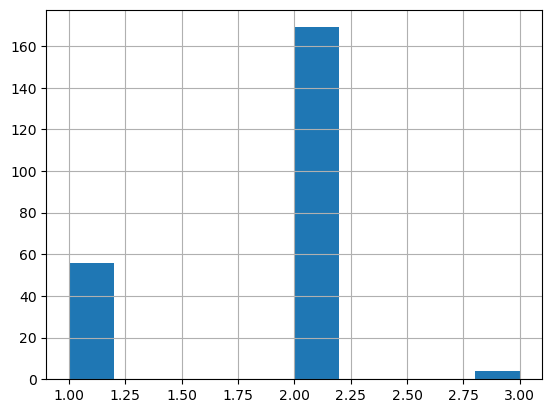

In [57]:
display(df_hits.drop_duplicates(subset=["cui"]).query("shortest_path_length<50").shortest_path_length.hist())


In [58]:
df_hits.loc[df_hits["feature_name"].str.contains('obes',case=False)| df_hits["cui_nomenclature"].str.contains('obes',case=False)]

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits,sim_score_target_feat,...,feature_importance,p_val,corr,MutualInfoTarget,F.Split-Lift (y==1),F.Split-Support,F.Split-Feature Split,shortest_path_length,simple_path_length,norm_path_length


### Save output report
* Saves highly filtered (heuristic) candiadtes, eg.g with no kg hits. (+- path length?)

In [59]:
if SAVE_OUTPUTS:
    # for c in list_target_cuis: ## manually append it hewre with some of the feature vals
    #     df_hits._append({"cui":c,"feature_name":"target","cui_nomenclature":linker.kb.cui_to_entity[c][1]}, ignore_index=True) 

    df_hits["cui"] = df_hits["cui"].astype(str)
    print(CANDIDATE_NOVEL_CUIS_FILEPATH)
    df_temp = df_hits.query("KG_Hits==0 & feature_level_avg_kg_hits<0.7")
    # df_temp = df_hits.query("shortest_path_length>2 & feature_level_avg_kg_hits<=0.75")
    df_temp.to_csv(CANDIDATE_NOVEL_CUIS_FILEPATH,index=False)
    display(df_temp)

In [60]:
# df_hits.query("KG_Hits==0 & feature_level_sum_kg_hits==0").drop_duplicates(["cui"]).drop_duplicates(["feature_name"]).iloc[:,0:3]  # "feature_name",

df_hits.query("shortest_path_length>2 & KG_Hits==0 & feature_level_sum_kg_hits<=2 & feature_level_avg_kg_hits<0.5 & p_val<0.04").drop_duplicates(["cui"]).drop_duplicates(["feature_name"])#.iloc[:,0:3]  # "feature_name",

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits,sim_score_target_feat,...,feature_importance,p_val,corr,MutualInfoTarget,F.Split-Lift (y==1),F.Split-Support,F.Split-Feature Split,shortest_path_length,simple_path_length,norm_path_length
5,Coffee intake,C1512806,Intake,"Intake. The process of taking in a substance, ...",0,0.474,0.0,1.0,0.3,0.04,...,0.1241,0.0000,0.006,0.0026,1.18,25784,-1.10 <= Coffee intake < -0.70,99,0,0.0
7,Home area population density - urban or rural ...,C0442529,Urban environment,Urban environment. A delineated geographic are...,0,0.319,0.0,0.0,0.0,-0.06,...,0.1226,0.0000,-0.005,0.0023,1.04,87074,Home area population density - urban or rural_...,999,0,0.0
21,Z51.5 - Palliative care,C0557533,Hospice and Palliative Care Nursing,Hospice and Palliative Care Nursing. A nursing...,0,0.529,0.0,0.0,0.0,-0.00,...,0.0752,0.0000,0.011,0.0034,1.01,90102,missing_Z51.5 - Palliative care >= -3.80,999,0,0.0
23,Weight change compared with 1 year ago Yes - g...,C1298907,Yes - Presence findings,Yes - Presence findings.,0,0.289,0.0,1.0,0.2,0.12,...,0.0660,0.0004,0.000,0.0031,1.02,65213,Weight change compared with 1 year ago_Yes - g...,99,0,0.0
30,SHBG,C0312446,Somatotropin binding globulin,Somatotropin binding globulin.,0,0.518,0.0,0.0,0.0,0.02,...,0.0478,0.0000,0.008,0.0043,1.81,138,0.22 <= SHBG < 0.23,99,0,0.0
37,Body mass index (BMI) (participant - p21001 i0),C2698741,Participant Object,Participant Object. Something that takes part ...,0,0.253,0.0,1.0,0.3,0.06,...,0.0461,0.0000,0.001,0.0000,1.27,7416,Body mass index (BMI)(participant - p21001_i0)...,99,0,0.0
45,Microalbumin in urine,C0042037,In Urine,In Urine. Used for the presence or analysis of...,0,0.516,0.0,0.0,0.0,0.15,...,0.0354,0.0000,-0.005,0.0043,4.07,194,Microalbumin in urine >= 9.60,99,0,0.0
48,Cholesterol Blood biochemistry,C0005477,Biochemistry,"Biochemistry. The study of the composition, ch...",0,0.439,0.0,0.0,0.0,0.10,...,0.0333,0.0000,-0.002,0.0011,1.35,4841,Cholesterol Blood biochemistry < -1.60,999,0,0.0
54,"Never eat eggs, dairy, wheat, sugar I eat all ...",C0981883,whole wheat allergenic extract,whole wheat allergenic extract.,0,0.400,0.0,2.0,0.3,-0.06,...,0.0307,0.0000,-0.007,0.0178,1.18,26041,"Never eat eggs, dairy, wheat, sugar_I eat all ...",99,0,0.0
59,Total protein,C1261360,Total protein result,Total protein result.,0,0.923,0.0,0.0,0.0,0.10,...,0.0255,0.0000,-0.003,0.0010,1.65,1282,Total protein >= 2.50,99,0,0.0


Featues without known links in db for sepsis: 
* 'Diastolic BP (Blood Pressure mm Hg)'
    *  2023; "Association between diastolic blood pressure during the first 24 h and 28-day mortality in patients with septic shock" ; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10492407/#:~:text=It%20has%20been%20confirmed%20that,mortality%20%5B14%2C%2015%5D :
    ```"It has been confirmed that low level of DBP, not systolic blood pressure and MAP, was the independent predictor of early progression to septic shock , associated with the development of acute kidney injury (AKI), and significantly associated with in-hospital mortality"```
*  'pH (blood pH)'
    * sepsis affects this ?
    * "Blood pH is normally maintained tightly between 7.35 and 7.45, and lactic acidosis with a pH <7.3 indicates a poor prognosis in sepsis, also associated with low zinc levels."  
*   'Hct Hematocrit (%)'
    * 2022 paper found a link - "Association between hematocrit and the 30-day mortality of patients with sepsis: A retrospective analysis based on the large-scale clinical database MIMIC-IV" https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8947025/   



* For Gallstones -
* * One "novelty" (no links found) that maybe shouldnt be is `Duodenitis`
  * e.g., Acute cholecystitis and duodenitis associated with Churg-Strauss syndrome https://pubmed.ncbi.nlm.nih.gov/12845966/
 * https://www.drpapoulas.com/condition-procedure/gallbladder-disease/ : 
```
Most patients with chronic cholecystitis were found to have gallstones within the gallbladder. It is important to obtain a complete history and physical examination to rule out other potential causes of pain, such as duodenitis, peptic ulcer disease, gastritis, 
```

In [61]:
# ## check that term exists in the full KG
# df_kg.loc[(df_kg["SUBJECT_NAME"].str.contains("Duodenit",case=False)) | (df_kg["OBJECT_NAME"].str.contains("Duodenit",case=False))].shape[0]

# Foward Temporal eval
### Check which links/features from our data appear in "future" data 
* Take KG, split to train/test by time (e.g. 2014 onwards), if a link appears in 2014 onwads and not in earlier , then it is a possible case of a novel detection from our model.
* Need to consider how to filter cuis/features. e.g. overly common cui nomenclatures

In [62]:
KG_YEAR_CUTOFF = 2013
print(KG_YEAR_CUTOFF,"KG_YEAR_CUTOFF")

2013 KG_YEAR_CUTOFF


In [63]:
df_hits["cui_count"] = df_hits.groupby(["cui"]).transform("size")

In [64]:
# df_kg_sep.shape[0] # 5139
# df_kg_sep.drop_duplicates(["SUBJECT_CUI","OBJECT_CUI"]).shape[0] # 5030
# df_kg_sep.drop_duplicates(["SUBJECT_CUI","OBJECT_CUI","PREDICATE"]).shape[0] # 5056
df_kg_sep.drop_duplicates(["SUBJECT_CUI","OBJECT_CUI","first_year_pair"]).shape[0] # 5031

2384

In [65]:
df_kg_sep.nunique()

SUBJECT_CUI          1684
SUBJECT_NAME         1735
SUBJECT_SEMTYPE        70
PREDICATE              31
SUBJECT_NOVELTY         2
OBJECT_CUI            702
OBJECT_NAME           726
OBJECT_SEMTYPE         39
OBJECT_NOVELTY          2
first_year_pair       110
first_year_triple     110
counts                 59
dtype: int64

In [66]:
df_kg_sep["first_year_pair"].describe().round()

count    2461.0
mean     2003.0
std        26.0
min      1785.0
25%      1993.0
50%      2013.0
75%      2019.0
max      2024.0
Name: first_year_pair, dtype: float64

In [67]:
df_kg_past = df_kg_sep.loc[df_kg_sep["first_year_pair"]<KG_YEAR_CUTOFF]
print("past",df_kg_past.shape[0])
df_kg_future = df_kg_sep.loc[df_kg_sep["first_year_pair"]>=KG_YEAR_CUTOFF]
print("Future, before filter/antijoin",df_kg_future.shape[0])

past 1203
Future, before filter/antijoin 1258


In [68]:
df_kg_future = anti_join_df(left=df_kg_future, right=df_kg_past, key=["SUBJECT_CUI","OBJECT_CUI"])
df_kg_future

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,PREDICATE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,first_year_pair,first_year_triple,counts
0,,None,gngm,ASSOCIATED_WITH,False,C0018099,Gout,dsyn,True,2023.0,2023.0,1.0
1,10246,SLC17A2,gngm,ASSOCIATED_WITH,True,C0018099,Gout,dsyn,True,2018.0,2018.0,1.0
2,10257,ABCC4,gngm,ASSOCIATED_WITH,True,C0018099,Gout,dsyn,True,2017.0,2017.0,1.0
6,116449,CLNK,gngm,ASSOCIATED_WITH,True,C0018099,Gout,dsyn,True,2015.0,2015.0,1.0
8,1277,COL1A1,gngm,PREDISPOSES,False,C0018099,Gout,dsyn,True,2022.0,2022.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2456,C5392186,Risk Scores,fndg,NEG_PREDISPOSES,True,C0018099,Gout,dsyn,True,2020.0,2020.0,1.0
2457,C5392203,Oxidative Damage,comd,CAUSES,True,C0018099,Gout,dsyn,True,2023.0,2023.0,1.0
2458,C5396784,Point of care ultrasound,diap,DIAGNOSES,True,C0018099,Gout,dsyn,True,2021.0,2021.0,1.0
2459,C5396824,Urate lowering therapy,topp,TREATS,True,C0018099,Gout,dsyn,True,2020.0,2020.0,49.0


In [69]:
past_cuis_list = list(set(df_kg_past["SUBJECT_CUI"].unique().tolist() + df_kg_past["OBJECT_CUI"].unique().tolist()))
print("# past cuis",len(past_cuis_list))

future_cuis_list = list(set(df_kg_future["SUBJECT_CUI"].unique().tolist() + df_kg_future["OBJECT_CUI"].unique().tolist()))
print("# future cuis",len(future_cuis_list))
future_cuis_list = [x for x in future_cuis_list if x not in past_cuis_list]
print("# future cuis, not in past",len(future_cuis_list))

# past cuis 1043
# future cuis 1164
# future cuis, not in past 1101


## Keep only (model) features that appear in the future, not past , of the KG

* Additional possible filter needed: If any cui (perfeature) is a match in PAST data?
    * Would need to filter out overly common cuis (e.g. "genetic risk") in such a case or multiples...  
* Q: Important filter note: Might want to filter by first appearance/year of a specific cui? e.g. to avoid cases where cui was only added after cutoff. This is arguable, as a novelty might legitiamtely be added as a cui after cutoff..

In [70]:
df_hits_future = df_hits.loc[df_hits["cui"].isin(future_cuis_list)].copy()
print(df_hits_future.shape[0], "# Rows")
print("nunique:")
# print(df_hits_future.groupby(["SUBJECT_CUI","OBJECT_CUI"]).size(), "# Subj X Obj cui unique Pairs")
print(df_hits_future.nunique())
print("\nfeature #:")
print(df_hits_future.feature_name.value_counts().head(11))
print("\ncui #:")
print(df_hits_future.cui_nomenclature.value_counts().head(11))


138 # Rows
nunique:
feature_name                 126
cui                           27
cui_nomenclature              27
cui_def                       27
KG_Hits                        3
sim_score                     40
feature_level_min_kg_hits      2
feature_level_sum_kg_hits      4
feature_level_avg_kg_hits      8
sim_score_target_feat         37
sim_score_target_cui          42
feature_importance            82
p_val                         66
corr                          34
MutualInfoTarget              56
F.Split-Lift (y==1)           59
F.Split-Support              124
F.Split-Feature Split        126
shortest_path_length           2
simple_path_length            27
norm_path_length              13
cui_count                      4
dtype: int64

feature #:
feature_name
Frequency of depressed mood in last 2 weeks                                    2
Weight change compared with 1 year ago Yes - gained weight                     2
Poisoning by analgesics, antipyretics, and antirheumat

### Get feature level (vs cui) level matched hits in past and then use that for filtering
* Will take higher confidence cuis/terms (to reduce noise)
* We remove very common cuis that are too broad (e.g. "gene risk"). Set at 97% quantile (5 in our case for gallstones)

In [71]:
df_hits_past = df_hits.loc[df_hits["cui"].isin(past_cuis_list)].copy()
print(df_hits_past.shape[0],"# rows\n")
print(df_hits_past.select_dtypes(["O","category"]).nunique(),"\n")

## redo cui count to use past data, avoid future information leak. Note: distribution looks about the same.
df_hits_past["cui_count"] = df_hits_past.groupby(["cui"]).transform("size")

# print(df_hits_past["cui_count"].describe(percentiles=[.5,.9,.97]).round(1))
display(df_hits_past.drop_duplicates(["cui"])["cui_count"].describe(percentiles=[.5,.9,.95,.98]).round(1)) # avoid double counting cuis
past_cui_count_cutoff = max(df_hits_past.drop_duplicates(["cui"])["cui_count"].quantile(0.98),2)
print("cui cutoff for past:",past_cui_count_cutoff)
df_hits_past = df_hits_past.loc[df_hits_past["cui_count"]<past_cui_count_cutoff]
print("\nAfter cui cutoff filter:\n")
print(df_hits_past.shape[0],"# rows\n")
print(df_hits_past.select_dtypes(["O","category"]).nunique(),"\n")

81 # rows

feature_name             59
cui                      40
cui_nomenclature         40
cui_def                  40
F.Split-Feature Split    59
dtype: int64 



count    40.0
mean      2.0
std       1.9
min       1.0
50%       1.0
90%       3.1
95%       5.0
97%       5.8
max      11.0
Name: cui_count, dtype: float64

cui cutoff for past: 5.829999999999998

After cui cutoff filter:

64 # rows

feature_name             47
cui                      38
cui_nomenclature         38
cui_def                  38
F.Split-Feature Split    47
dtype: int64 



### Get results - # features in future and not in past, out of all utility featues
* Additional filter - rmeoval of "common" cui terms from the future results also (not just past). 

In [72]:
print(f'Out of {df_hits.query("KG_Hits>0")["feature_name"].nunique()} Features with any hit in KG')
# print(df_hits_future["feature_name"].nunique(),"# future feats pre past filt")
df_hits_future = df_hits_future.loc[(~df_hits_future["cui"].isin(df_hits_past["cui"])) & (~df_hits_future["feature_name"].isin(df_hits_past["feature_name"]))]
print(df_hits_future["feature_name"].nunique(),"# future feats after past filt")

Out of 89 Features with any hit in KG
105 # future feats after past filt


* Filter out common cuis like with past
* Use overall count instead of future only count of those cuis
* This filtering may be excessive? 

In [73]:
df_hits_future = df_hits_future.loc[df_hits_future["cui_count"]<=past_cui_count_cutoff]
print(df_hits_future.drop_duplicates("feature_name").shape[0])
display(df_hits_future.drop_duplicates("feature_name"))

30


,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits,sim_score_target_feat,...,p_val,corr,MutualInfoTarget,F.Split-Lift (y==1),F.Split-Support,F.Split-Feature Split,shortest_path_length,simple_path_length,norm_path_length,cui_count
16,Water intake,C0013123,Water consumption,Water consumption. A measurement of a subject'...,1,0.816,1.0,1.0,1.0,0.08,...,0.0000,0.005,0.0011,1.33,8134,1.30 <= Water intake < 9.00,1,117,0.05,1
17,Tea intake,C0039400,Tea,Tea. The infusion of leaves of CAMELLIA SINENS...,1,0.545,0.0,1.0,0.3,0.02,...,0.0000,-0.002,0.0018,1.14,220,Tea intake < -1.30,1,118,0.20,1
26,Weight change compared with 1 year ago Yes - g...,C0043100,Weight,Weight. The vertical force exerted by a mass a...,1,0.201,0.0,1.0,0.2,0.12,...,0.0004,0.000,0.0031,1.02,65213,Weight change compared with 1 year ago_Yes - g...,1,5,0.02,3
35,Body mass index (BMI) (participant - p21001 i0),C0005893,Body mass index procedure,Body mass index procedure.,1,0.614,0.0,1.0,0.3,0.06,...,0.0000,0.001,0.0000,1.27,7416,Body mass index (BMI)(participant - p21001_i0)...,1,297,0.11,2
62,Weight (participant - p21002 i0),C0043100,Weight,Weight. The vertical force exerted by a mass a...,1,0.520,0.0,1.0,0.3,0.01,...,0.0000,-0.003,0.0000,1.73,330,Weight(participant - p21002_i0) >= 3.70,1,5,0.02,3
65,Genetic risk for multiple sclerosis (MS),C0026769,Multiple Sclerosis,Multiple Sclerosis. An autoimmune disorder mai...,1,0.661,0.0,1.0,0.5,-0.02,...,0.0041,-0.007,0.0020,1.37,614,Standard PRS for multiple sclerosis (MS) < -2.20,2,237,0.03,2
75,Haemoglobin concentration,C0019046,Hemoglobin,Hemoglobin. The oxygen-carrying proteins of ER...,1,0.724,0.0,1.0,0.5,0.08,...,0.0000,-0.015,0.0007,2.07,213,2.30 <= Haemoglobin concentration < 2.50,1,488,0.05,1
84,Weight change compared with 1 year ago Yes - l...,C0043100,Weight,Weight. The vertical force exerted by a mass a...,1,0.156,0.0,0.0,0.0,-0.01,...,0.0000,-0.006,0.0013,1.18,14173,Weight change compared with 1 year ago_Yes - l...,1,5,0.02,3
124,Essential hypertension,C0085580,Essential Hypertension,Essential Hypertension. Hypertension that occu...,1,0.751,1.0,1.0,1.0,0.18,...,0.0000,0.008,0.0113,1.34,32710,missing_Essential hypertension < -0.30,1,137,0.04,1
129,Genetic risk for type 1 diabetes (T1D),C0011854,"Diabetes Mellitus, Insulin-Dependent","Diabetes Mellitus, Insulin-Dependent. A chroni...",1,0.543,0.0,1.0,0.3,0.06,...,0.0824,0.009,0.0007,1.68,279,0.69 <= Standard PRS for type 1 diabetes (T1D)...,2,253,0.03,2


In [74]:
df_hits_future["feature_name"].unique()

array(['Water intake', 'Tea intake',
       'Weight change compared with 1 year ago Yes - gained weight',
       'Body mass index (BMI) (participant - p21001 i0)',
       'Weight (participant - p21002 i0)',
       'Genetic risk for multiple sclerosis (MS)',
       'Haemoglobin concentration',
       'Weight change compared with 1 year ago Yes - lost weight',
       'Essential hypertension', 'Genetic risk for type 1 diabetes (T1D)',
       'Ever had bowel cancer screening', 'Genetic risk for asthma (AST)',
       'Standing height', 'Congestive heart failure (CHF) NOS',
       'Genetic risk for body mass index (BMI)',
       'Date of all cause dementia report',
       'Genetic risk for height (HEIGHT)', 'Leg pain on walking',
       'Genetic risk for venous thromboembolic disease (VTE)',
       'Enhanced Genetic risk for height (HEIGHT)', 'Asthma',
       'Cellulitis and abscess of foot, toe', 'Cataract',
       'Z86.6 - Personal history of diseases of the nervous system and sense organs

In [75]:
# df_hits_past.query("sim_score<0.22").drop_duplicates(subset=["feature_name"]).head()

,feature_name,cui,cui_nomenclature,cui_def,KG_Hits,sim_score,feature_level_min_kg_hits,feature_level_sum_kg_hits,feature_level_avg_kg_hits,sim_score_target_feat,...,p_val,corr,MutualInfoTarget,F.Split-Lift (y==1),F.Split-Support,F.Split-Feature Split,shortest_path_length,simple_path_length,norm_path_length,cui_count
55,"Never eat eggs, dairy, wheat, sugar I eat all ...",C0007004,Carbohydrates,Carbohydrates. A class of organic compounds co...,1,0.216,0.0,2.0,0.3,-0.06,...,0.0000,-0.007,0.0178,1.18,26041,"Never eat eggs, dairy, wheat, sugar_I eat all ...",1,433,0.05,3
240,medication 50 inhaler,C0013227,Pharmaceutical Preparations,Pharmaceutical Preparations. Drugs intended fo...,1,0.183,0.0,0.0,0.0,-0.13,...,0.0027,0.009,0.0000,1.00,91053,Treatment/medication code | Array 0__50 inhale...,1,1011,0.02,5
300,"dietary changes in the last 5 years Yes, becau...",C0012155,Diet,Diet. Regular course of eating and drinking ad...,1,0.203,0.0,1.0,0.3,0.10,...,0.0226,0.004,0.0029,1.01,67296,"Major dietary changes in the last 5 years_Yes,...",1,266,0.10,2
363,medication 5mg tablet,C0013227,Pharmaceutical Preparations,Pharmaceutical Preparations. Drugs intended fo...,1,0.162,0.0,1.0,0.3,-0.06,...,0.0397,-0.003,0.0003,1.00,91195,Treatment/medication code | Array 0__5mg table...,1,1011,0.02,5
434,"Never eat eggs, dairy, wheat, sugar Eggs or fo...",C0007004,Carbohydrates,Carbohydrates. A class of organic compounds co...,1,0.194,0.0,2.0,0.2,-0.09,...,0.0010,0.002,0.0006,1.40,599,"Never eat eggs, dairy, wheat, sugar_Eggs or fo...",1,433,0.05,3
